In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# CSVファイルを読み込む
df = pd.read_csv('~/lab/data/dataset/dataset_all.csv')

# データフレームの基本情報を表示
print("データフレームの形状:", df.shape)
print("\nデータフレームの最初の行:")
print(df.head())
print("\nデータフレームの統計情報:")
print(df.describe())
print("\nデータ型:")
print(df.dtypes)
print("\nNULL値の確認:")
print(df.isnull().sum())

# Charge_err(pC)列の存在確認
if 'Charge_err(pC)' in df.columns:
    print("\n✓ Charge_err(pC)列が存在します")
    print("Charge_err(pC)の統計:")
    print(df['Charge_err(pC)'].describe())
else:
    print("\n✗ 警告: Charge_err(pC)列が見つかりません")
    print("利用可能な列:", df.columns.tolist())

データフレームの形状: (1068, 13)

データフレームの最初の行:
   #PMT_num  Charge(pC)  Charge_err(pC)  light_power(def:(15dB, 5V)=1)  \
0         1    12.54370        0.032363                       0.279857   
1         2     9.33347        0.027628                       0.279857   
2         3    26.87980        0.048025                       0.279857   
3         4    14.78670        0.035142                       0.279857   
4         1    13.82240        0.033406                       0.280068   

   attenuation_db  pd_volt   x   y    z           r  cos(alpha)  \
0              20  4.42493 -35 -35  157  103.693057    0.737754   
1              20  4.42493 -35 -35  157  125.108953    0.611467   
2              20  4.42493 -35 -35  157   76.500000    1.000000   
3              20  4.42493 -35 -35  157  103.693057    0.737754   
4              20  4.42826 -35 -35  147   96.551800    0.688749   

   r_from_center  cos(alpha_from_center)  
0     129.541499                0.841429  
1     147.244694            

全モデルの2回フィット実行（1回目の結果を初期値として2回目を実行）

MODEL A: y=c0*(1-sqrt(1-(30/r)^2))
初期値: [1600.0]
  PMT 1 (x=-35, y=35):
    1回目: params=[1841.41118104], Chi2/NDF=1223
    2回目: params=[1841.41118104], Chi2/NDF=1223
  PMT 2 (x=35, y=35):
    1回目: params=[1940.97820461], Chi2/NDF=4581
    2回目: params=[1940.97820461], Chi2/NDF=4581
  PMT 3 (x=-35, y=-35):
    1回目: params=[2510.50786694], Chi2/NDF=1691
    2回目: params=[2510.50786694], Chi2/NDF=1691
  PMT 4 (x=35, y=-35):
    1回目: params=[2158.38750794], Chi2/NDF=2621
    2回目: params=[2158.38750794], Chi2/NDF=2621

MODEL B: y=c0*(1-sqrt(1-(c1/r)^2))
初期値: [1600.0, 30]
  PMT 1 (x=-35, y=35):
    1回目: params=[1303.72428782   35.01772816], Chi2/NDF=334.3
    2回目: params=[1303.72531357   35.01771637], Chi2/NDF=334.3
  PMT 2 (x=35, y=35):
    1回目: params=[1314.23327448   35.40294521], Chi2/NDF=815.1
    2回目: params=[1314.23334907   35.40294442], Chi2/NDF=815.1
  PMT 3 (x=-35, y=-35):
    1回目: params=[1988.11074578   33.25410338], Chi2/NDF=811.9
    2回目: param

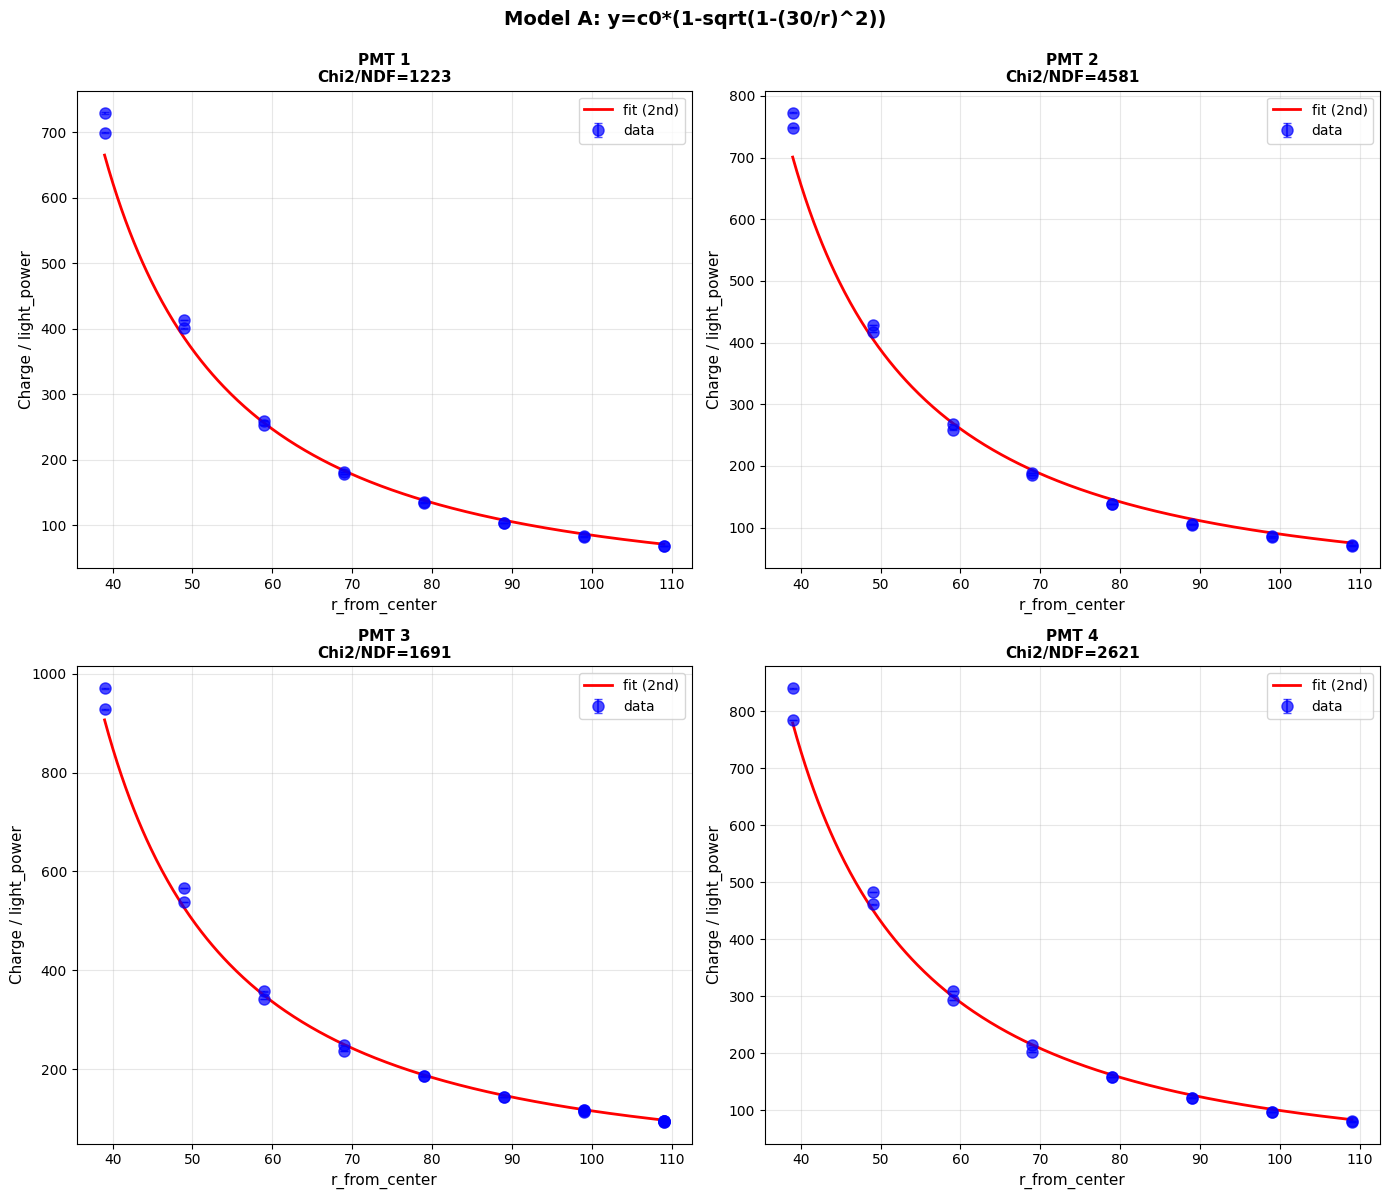


MODEL B グラフ作成中...


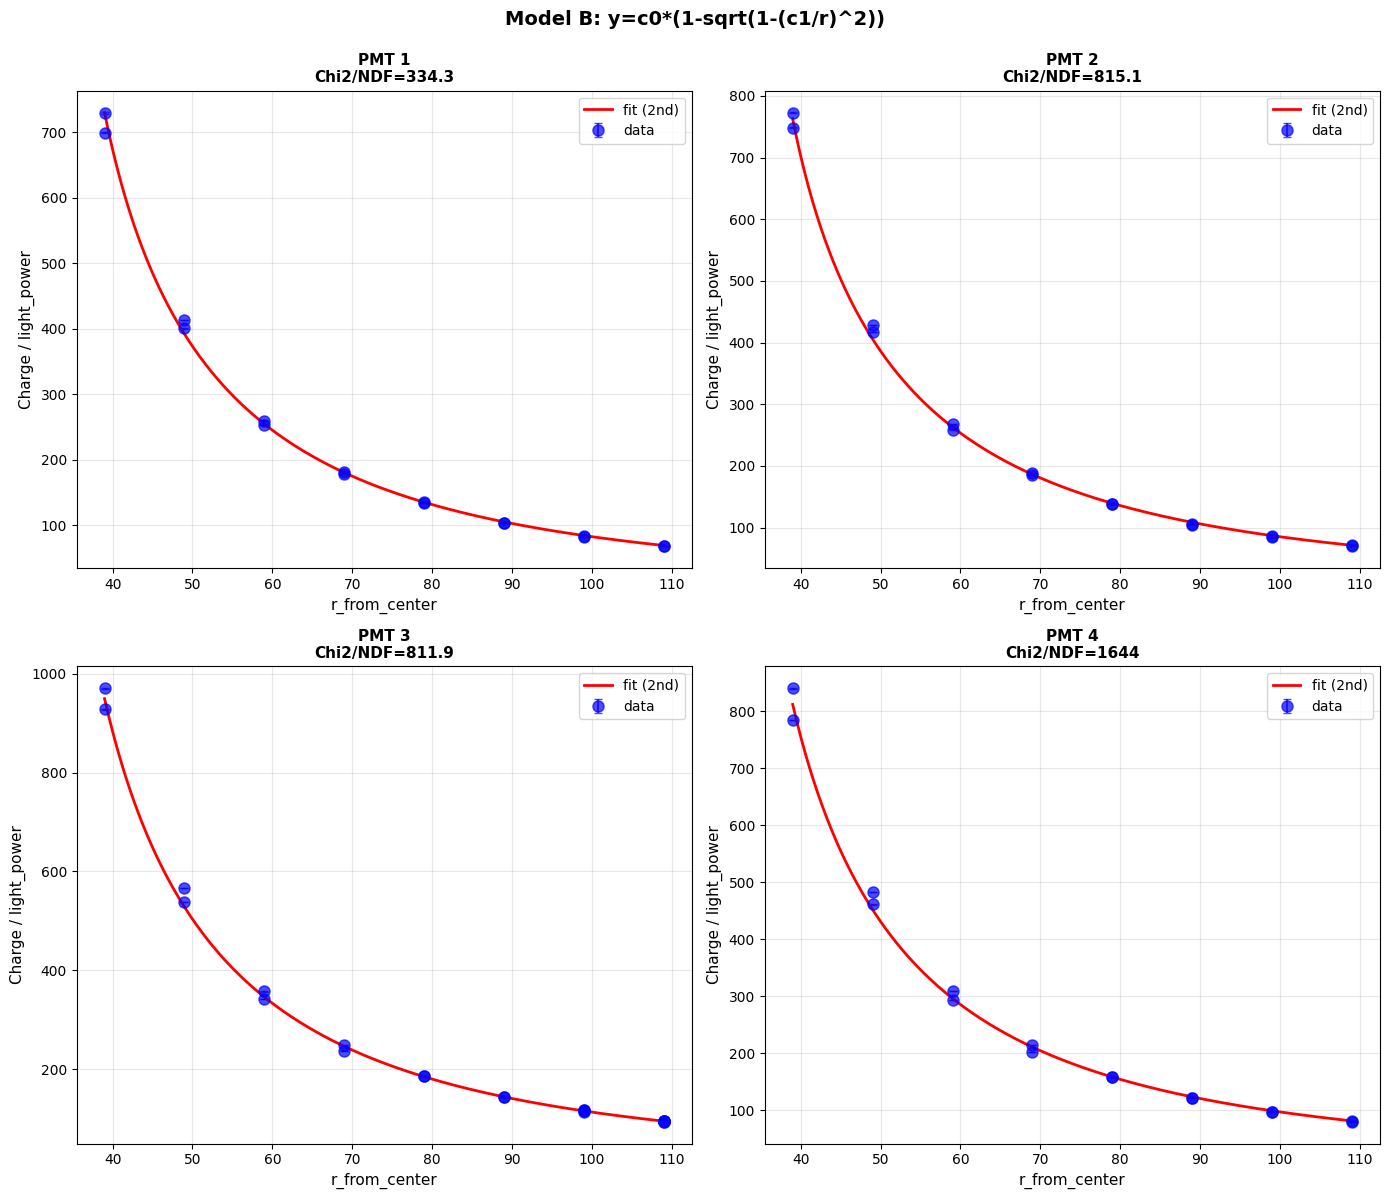


MODEL C グラフ作成中...


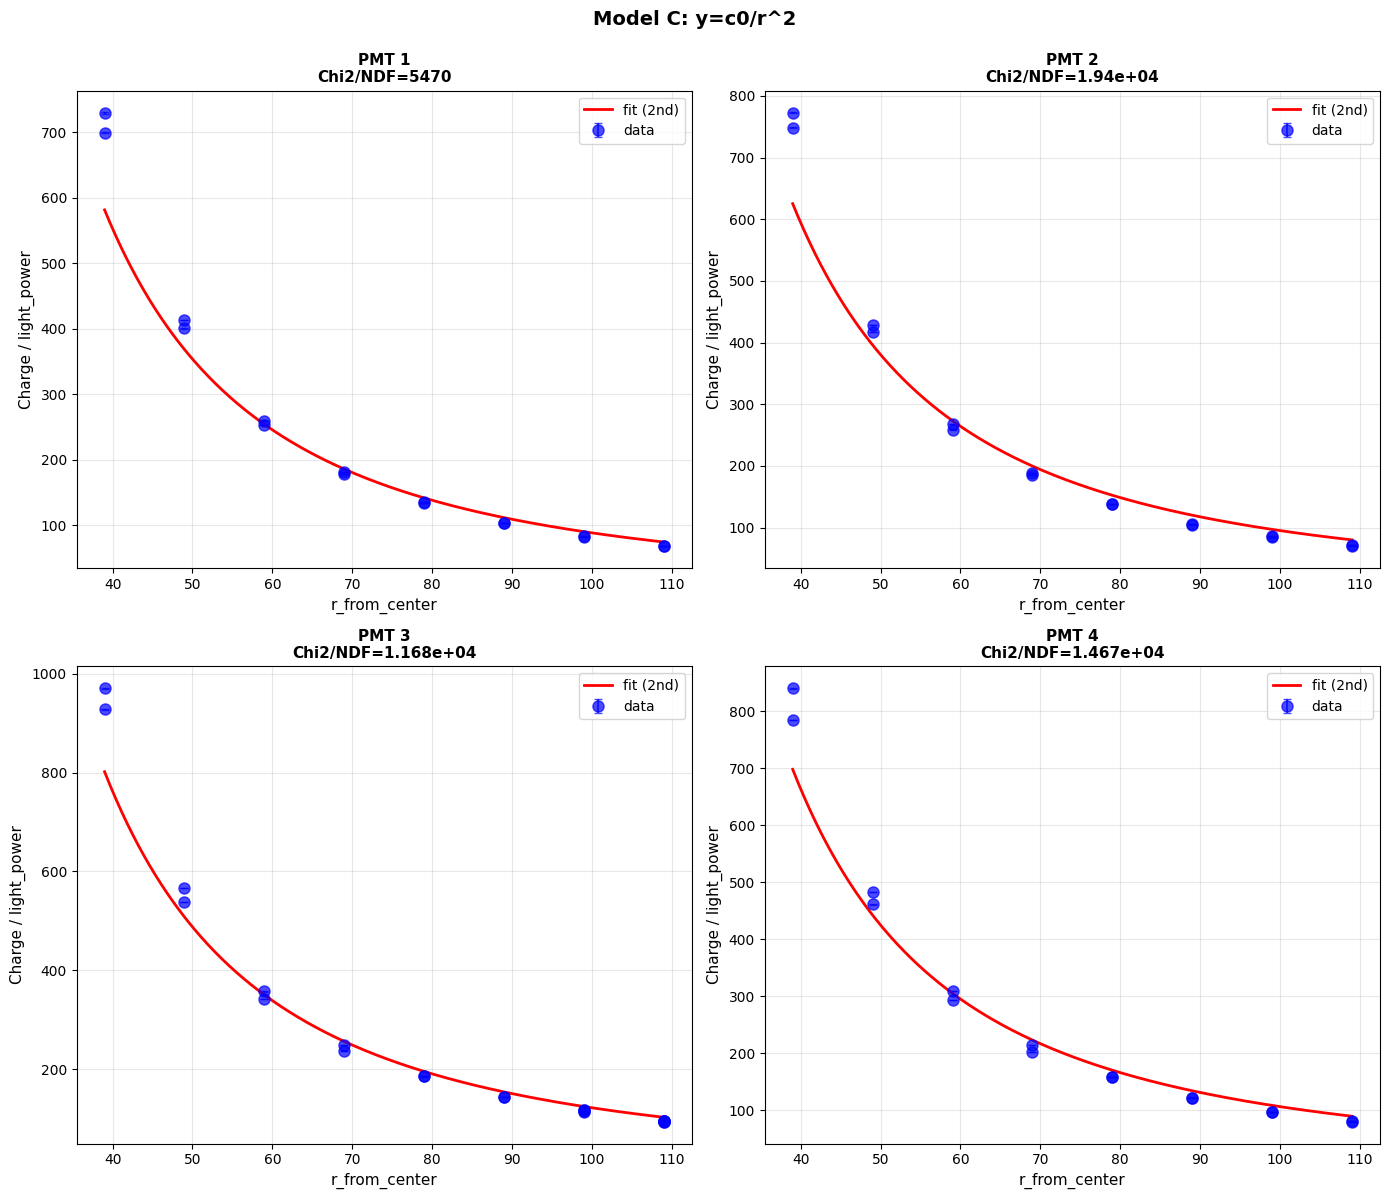


MODEL D グラフ作成中...


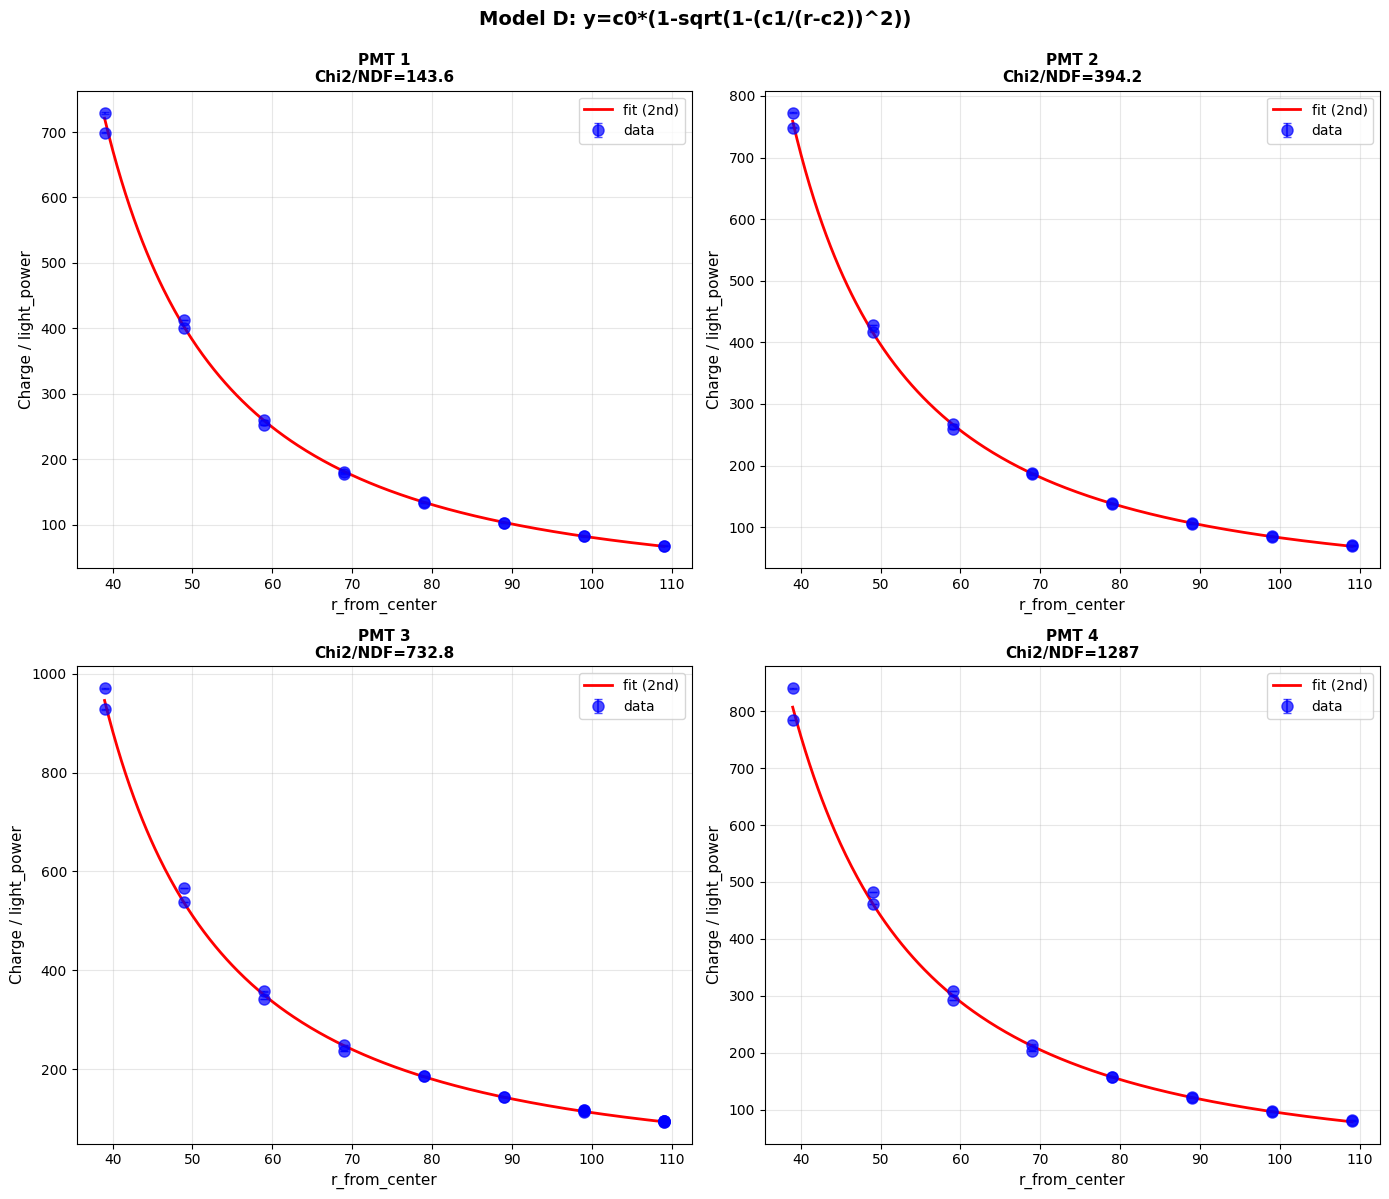


MODEL E グラフ作成中...


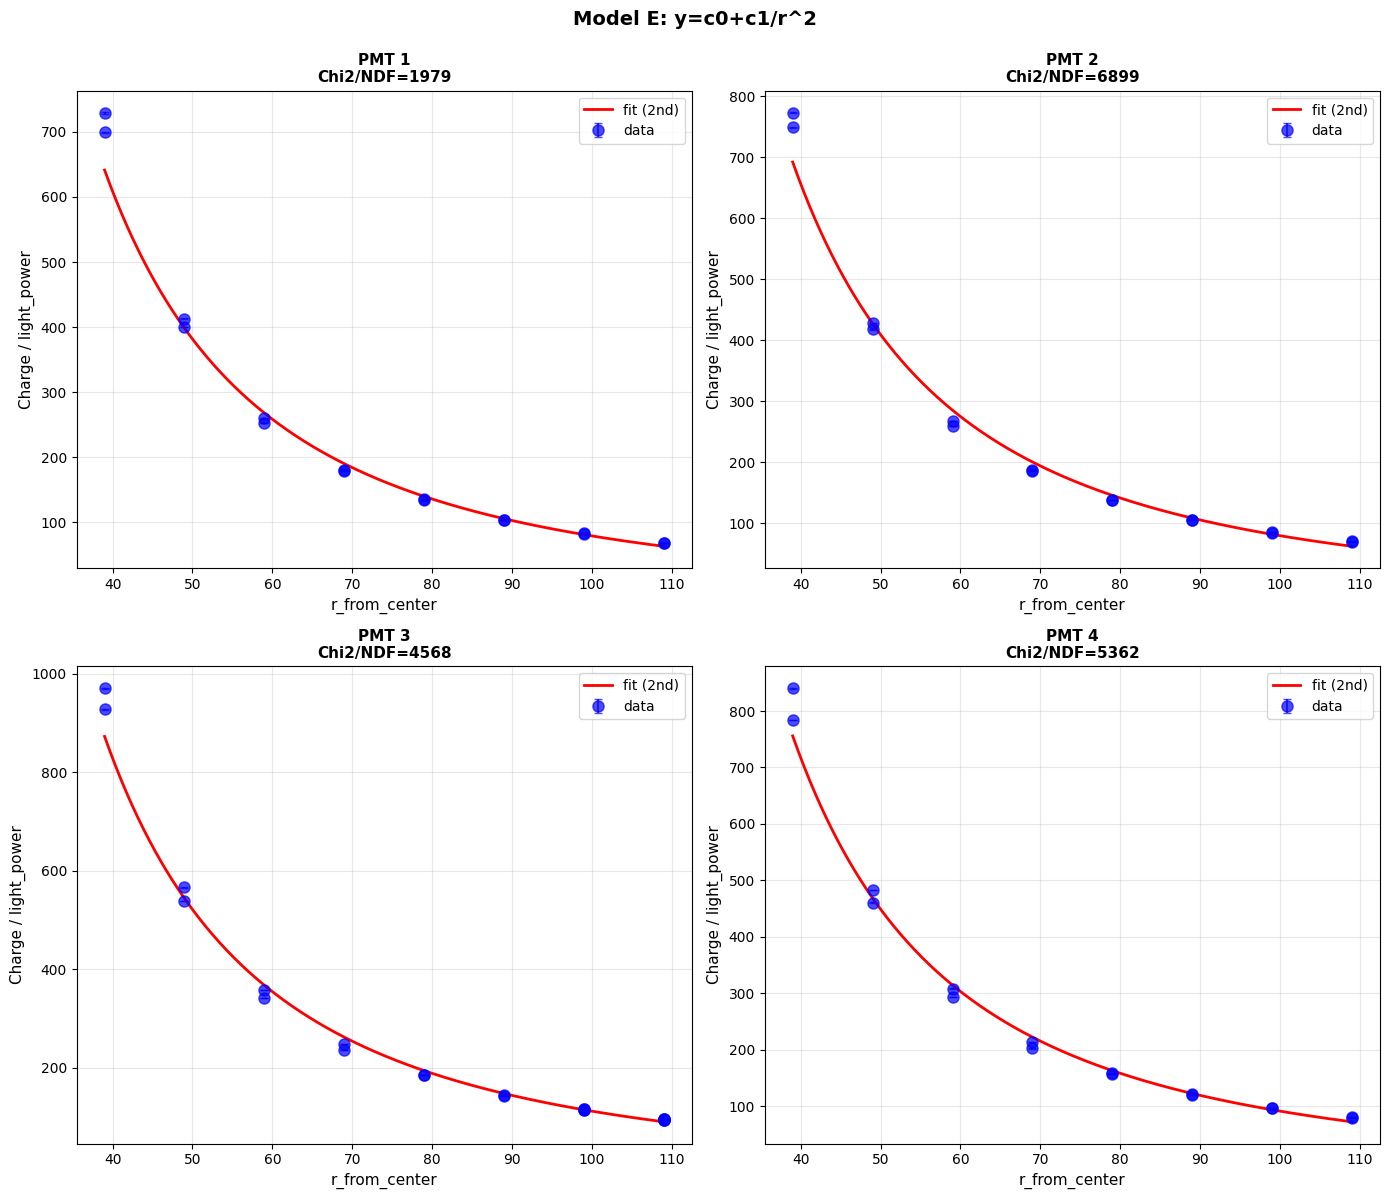


MODEL F グラフ作成中...


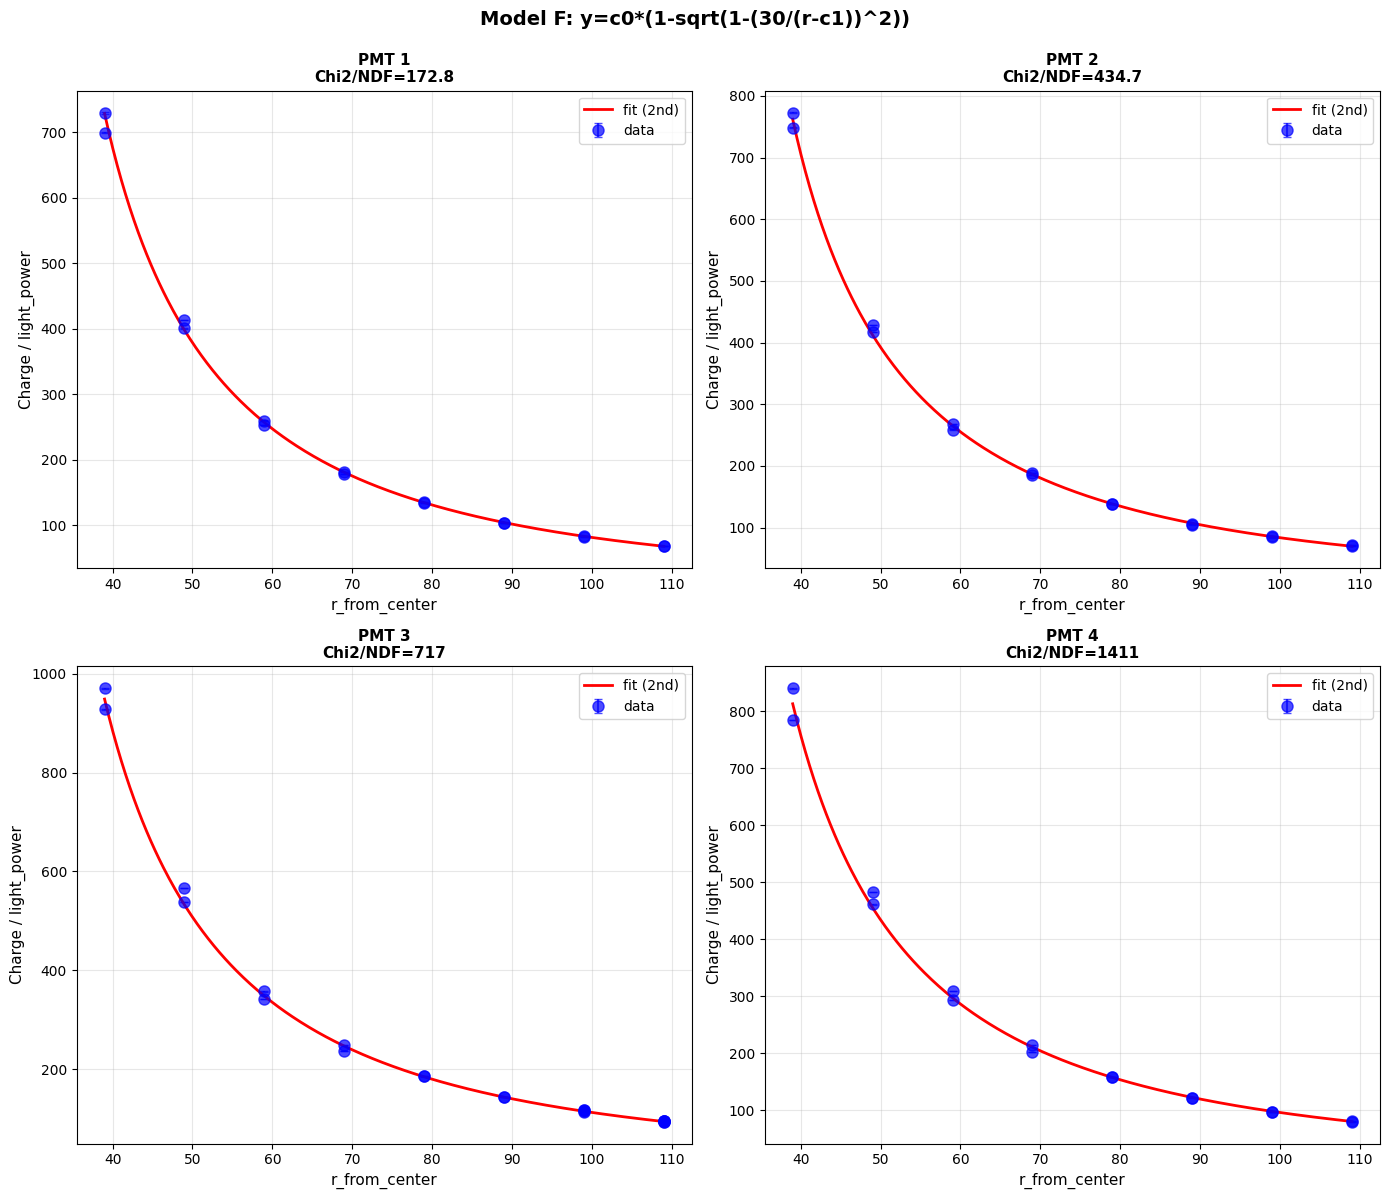


全モデル比較テーブル（2回目のフィット結果）
   Model  PMT   N     Chi2/NDF                                                                       Parameters
--------------------------------------------------------------------------------------------------------------------------------------------
       A    1  16         1223                                                                             1841
       A    2  16         4581                                                                             1941
       A    3  22         1691                                                                             2511
       A    4  16         2621                                                                             2158
       B    1  16        334.3                                                                      1304, 35.02
       B    2  16        815.1                                                                       1314, 35.4
       B    3  22        811.9                     

In [31]:
# 全モデルの2回フィット実行（1回目の結果を初期値として2回目を実行）
# Model A: y = c0 * (1 - sqrt(1 - (30/r)^2))
# Model B: y = c0 * (1 - sqrt(1 - (c1/r)^2))
# Model C: y = c0/r^2
# Model D (改): y = c0 * (1 - sqrt(1 - (c1/(r-c2))^2))  初期値変更
# Model E: y = c0 + c1/r^2
# Model F (新規): y = c0 * (1 - sqrt(1 - (30/(r-c1))^2))
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# PMT設定
pmt_configs = [
    (1, -35, 35),
    (2, 35, 35),
    (3, -35, -35),
    (4, 35, -35)
]

# ============================================================================
# モデル定義
# ============================================================================
a_const = 30

def model_a(r, c0):
    """Model A: y = c0 * (1 - sqrt(1 - (30/r)^2))"""
    return c0 * (1.0 - np.sqrt(1.0 - (a_const / r) ** 2))

def model_b(r, c0, c1):
    """Model B: y = c0 * (1 - sqrt(1 - (c1/r)^2))"""
    return c0 * (1.0 - np.sqrt(1.0 - (c1 / r) ** 2))

def model_c(r, c0):
    """Model C: y = c0/r^2"""
    return c0 / (r ** 2)

def model_d(r, c0, c1, c2):
    """Model D: y = c0 * (1 - sqrt(1 - (c1/(r-c2))^2))"""
    return c0 * (1.0 - np.sqrt(1.0 - (c1 / (r - c2)) ** 2))

def model_e(r, c0, c1):
    """Model E: y = c0 + c1/r^2"""
    return c0 + c1 / (r ** 2)

def model_f(r, c0, c1):
    """Model F: y = c0 * (1 - sqrt(1 - (30/(r-c1))^2))"""
    return c0 * (1.0 - np.sqrt(1.0 - (a_const / (r - c1)) ** 2))

# ============================================================================
# 2回フィット実行関数
# ============================================================================
def double_fit(model_func, x, y, y_err, p0_initial, n_params, model_name, pmt_num):
    """2回フィットを実行（1回目の結果を初期値として2回目を実行）"""
    
    if len(x) < n_params + 1:
        return None, None, None
    
    try:
        # 1回目のフィット
        popt1, _ = curve_fit(model_func, x, y, p0=p0_initial, 
                            sigma=y_err, absolute_sigma=True, maxfev=20000)
        
        y_fit1 = model_func(x, *popt1)
        residuals1 = (y - y_fit1) / y_err
        chi2_1 = np.sum(residuals1**2)
        ndf1 = len(x) - n_params
        chi2_ndf_1 = chi2_1 / ndf1 if ndf1 > 0 else float('inf')
        
        # 2回目のフィット（1回目の結果を初期値として使用）
        popt2, _ = curve_fit(model_func, x, y, p0=popt1, 
                            sigma=y_err, absolute_sigma=True, maxfev=20000)
        
        y_fit2 = model_func(x, *popt2)
        residuals2 = (y - y_fit2) / y_err
        chi2_2 = np.sum(residuals2**2)
        ndf2 = len(x) - n_params
        chi2_ndf_2 = chi2_2 / ndf2 if ndf2 > 0 else float('inf')
        
        result1 = {
            'pmt': pmt_num,
            'params': popt1,
            'chi2': chi2_1,
            'ndf': ndf1,
            'chi2_ndf': chi2_ndf_1,
            'success': True,
            'n_points': len(x)
        }
        
        result2 = {
            'pmt': pmt_num,
            'params': popt2,
            'chi2': chi2_2,
            'ndf': ndf2,
            'chi2_ndf': chi2_ndf_2,
            'success': True,
            'n_points': len(x)
        }
        
        # プロット用データ
        x_fit = np.linspace(np.min(x), np.max(x), 400)
        y_fit_plot = model_func(x_fit, *popt2)
        plot_data = {
            'pmt': pmt_num,
            'x': x,
            'y': y,
            'y_err': y_err,
            'x_fit': x_fit,
            'y_fit': y_fit_plot
        }
        
        return result1, result2, plot_data
        
    except Exception as e:
        print(f"  {model_name} PMT {pmt_num}: Fit failed - {e}")
        return None, None, None

# ============================================================================
# 各モデルの処理
# ============================================================================
# 結果格納用
all_results = {
    'A': {'fit1': [], 'fit2': [], 'plot': []},
    'B': {'fit1': [], 'fit2': [], 'plot': []},
    'C': {'fit1': [], 'fit2': [], 'plot': []},
    'D': {'fit1': [], 'fit2': [], 'plot': []},
    'E': {'fit1': [], 'fit2': [], 'plot': []},
    'F': {'fit1': [], 'fit2': [], 'plot': []}
}

models = [
    ('A', model_a, [1600.0], 1, "y=c0*(1-sqrt(1-(30/r)^2))"),
    ('B', model_b, [1600.0, 30], 2, "y=c0*(1-sqrt(1-(c1/r)^2))"),
    ('C', model_c, [6000.0], 1, "y=c0/r^2"),
    ('D', model_d, [2000.0, 30, 0.0], 3, "y=c0*(1-sqrt(1-(c1/(r-c2))^2))"),
    ('E', model_e, [100.0, 6000.0], 2, "y=c0+c1/r^2"),
    ('F', model_f, [2000.0, 0.0], 2, "y=c0*(1-sqrt(1-(30/(r-c1))^2))")
]

print("="*100)
print("全モデルの2回フィット実行（1回目の結果を初期値として2回目を実行）")
print("="*100)

for model_name, model_func, p0_initial, n_params, formula in models:
    print(f"\n{'='*90}")
    print(f"MODEL {model_name}: {formula}")
    print(f"初期値: {p0_initial}")
    print('='*90)
    
    for pmt_num, x_coord, y_coord in pmt_configs:
        # フィルタリング
        filtered = df[(df['#PMT_num'] == pmt_num) & 
                      (df['x'] == x_coord) & 
                      (df['y'] == y_coord)].copy()
        
        filtered['charge_per_power'] = filtered['Charge(pC)'] / filtered['light_power(def:(15dB, 5V)=1)']
        filtered['charge_per_power_err'] = filtered['Charge_err(pC)'] / filtered['light_power(def:(15dB, 5V)=1)']
        filtered = filtered[filtered['charge_per_power'] >= 20]
        
        # 配列準備
        x = filtered['r_from_center'].to_numpy(dtype=float)
        y = filtered['charge_per_power'].to_numpy(dtype=float)
        y_err = filtered['charge_per_power_err'].to_numpy(dtype=float)
        
        # Model Aの場合のみr >= 30の条件を追加
        if model_name == 'A':
            mask = np.isfinite(x) & np.isfinite(y) & np.isfinite(y_err) & (x >= a_const) & (y_err > 0)
        else:
            mask = np.isfinite(x) & np.isfinite(y) & np.isfinite(y_err) & (y_err > 0)
        
        x = x[mask]
        y = y[mask]
        y_err = y_err[mask]
        
        # 2回フィット実行
        result1, result2, plot_data = double_fit(
            model_func, x, y, y_err, p0_initial, n_params, 
            f"Model {model_name}", pmt_num
        )
        
        if result1 is not None and result2 is not None:
            all_results[model_name]['fit1'].append(result1)
            all_results[model_name]['fit2'].append(result2)
            all_results[model_name]['plot'].append(plot_data)
            
            print(f"  PMT {pmt_num} (x={x_coord}, y={y_coord}):")
            print(f"    1回目: params={result1['params']}, Chi2/NDF={result1['chi2_ndf']:.4g}")
            print(f"    2回目: params={result2['params']}, Chi2/NDF={result2['chi2_ndf']:.4g}")
        else:
            # フィット失敗
            all_results[model_name]['fit1'].append({
                'pmt': pmt_num,
                'params': None,
                'chi2': None,
                'ndf': None,
                'chi2_ndf': None,
                'success': False,
                'n_points': len(x)
            })
            all_results[model_name]['fit2'].append({
                'pmt': pmt_num,
                'params': None,
                'chi2': None,
                'ndf': None,
                'chi2_ndf': None,
                'success': False,
                'n_points': len(x)
            })
            all_results[model_name]['plot'].append({
                'pmt': pmt_num,
                'x': np.array([]),
                'y': np.array([]),
                'y_err': np.array([]),
                'x_fit': np.array([]),
                'y_fit': np.array([])
            })

# ============================================================================
# 各モデルのグラフ表示（2x2グリッド）
# ============================================================================
for model_name, _, _, _, formula in models:
    print(f"\n{'='*90}")
    print(f"MODEL {model_name} グラフ作成中...")
    print('='*90)
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    axes = axes.flatten()
    
    for idx, data in enumerate(all_results[model_name]['plot']):
        ax = axes[idx]
        pmt_num = data['pmt']
        
        if len(data['x']) > 0:
            ax.errorbar(data['x'], data['y'], yerr=data['y_err'], fmt='o', alpha=0.7, 
                       capsize=3, markersize=8, label='data', color='blue')
            ax.plot(data['x_fit'], data['y_fit'], color='red', linewidth=2, label='fit (2nd)')
            ax.set_xlabel('r_from_center', fontsize=11)
            ax.set_ylabel('Charge / light_power', fontsize=11)
            
            res2 = all_results[model_name]['fit2'][idx]
            if res2['success']:
                ax.set_title(f"PMT {pmt_num}\nChi2/NDF={res2['chi2_ndf']:.4g}", 
                           fontsize=11, fontweight='bold')
            else:
                ax.set_title(f"PMT {pmt_num}: Fit Failed", fontsize=11, fontweight='bold')
        else:
            ax.text(0.5, 0.5, f'PMT {pmt_num}\nNo Data', ha='center', va='center', 
                   fontsize=12, transform=ax.transAxes)
        
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=10)
    
    plt.suptitle(f'Model {model_name}: {formula}', 
                fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()

# ============================================================================
# 結果テーブル表示（全モデル比較）
# ============================================================================
print("\n" + "="*140)
print("全モデル比較テーブル（2回目のフィット結果）")
print("="*140)
print(f"{'Model':>8} {'PMT':>4} {'N':>3} {'Chi2/NDF':>12} {'Parameters':>80}")
print("-"*140)

for model_name in ['A', 'B', 'C', 'D', 'E', 'F']:
    for idx, res2 in enumerate(all_results[model_name]['fit2']):
        if res2['success']:
            params_str = ', '.join([f"{p:.4g}" for p in res2['params']])
            print(f"{model_name:>8} {res2['pmt']:>4} {res2['n_points']:>3} {res2['chi2_ndf']:>12.4g} {params_str:>80}")
        else:
            print(f"{model_name:>8} {res2['pmt']:>4} {res2['n_points']:>3} {'FAILED':>12} {'N/A':>80}")

print("="*140)

# ============================================================================
# Chi2/NDF比較サマリー
# ============================================================================
print("\n" + "="*100)
print("Chi2/NDF サマリー（2回目のフィット結果）")
print("="*100)
print(f"{'PMT':>4} {'Model A':>12} {'Model B':>12} {'Model C':>12} {'Model D':>12} {'Model E':>12} {'Model F':>12}")
print("-"*100)

for pmt_idx in range(4):
    pmt_num = pmt_idx + 1
    row = f"{pmt_num:>4}"
    for model_name in ['A', 'B', 'C', 'D', 'E', 'F']:
        res2 = all_results[model_name]['fit2'][pmt_idx]
        if res2['success']:
            row += f" {res2['chi2_ndf']:>12.4g}"
        else:
            row += f" {'N/A':>12}"
    print(row)

print("="*100)

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings('ignore')

# PMT座標の定義
PMT_COORDS = {
    1: (-35, 35),
    2: (35, 35),
    3: (-35, -35),
    4: (35, -35)
}

Z_PMT_SURFACE = 80.5  # PMT表面のz座標

def analyze_pmt_center_height(r_pmt, df, show_plots=True):
    """
    r_pmtが与えられたとき、PMT中心高さでフィットを行う関数
    
    Parameters:
    -----------
    r_pmt : float
        PMT半径 [cm]
    df : pandas.DataFrame
        入力データフレーム
    
    Returns:
    --------
    results : list
        フィット結果
    fit_functions : dict
        PMTごとの関数オブジェクト
    chi2_totals : dict
        {pmt_num: chi2統計}
    """
    
    # データフレームのコピー
    df_work = df.copy()
    
    # 不要な列を削除
    cols_to_drop = ['r', 'cos(alpha)', 'r_from_center', 'cos(alpha_from_center)']
    df_work = df_work.drop(columns=[col for col in cols_to_drop if col in df_work.columns])
    
    # PMT中心のz座標
    z_pmt_center = Z_PMT_SURFACE - r_pmt
    
    # 各PMTについて、中心から光源までの距離と天頂角を計算
    df_work['r_pmt'] = np.nan
    df_work['cos_alpha_pmt'] = np.nan
    
    for pmt_num, (x_pmt, y_pmt) in PMT_COORDS.items():
        mask = df_work['#PMT_num'] == pmt_num
        dx = df_work.loc[mask, 'x'].values - x_pmt
        dy = df_work.loc[mask, 'y'].values - y_pmt
        dz = df_work.loc[mask, 'z'].values - z_pmt_center
        
        r = np.sqrt(dx**2 + dy**2 + dz**2)
        cos_alpha = dz / r
        
        df_work.loc[mask, 'r_pmt'] = r
        df_work.loc[mask, 'cos_alpha_pmt'] = cos_alpha
    
    # Charge/light_powerの誤差を計算
    df_work['charge_normalized'] = df_work['Charge(pC)'] / df_work['light_power(def:(15dB, 5V)=1)']
    df_work['charge_normalized_err'] = df_work['Charge_err(pC)'] / df_work['light_power(def:(15dB, 5V)=1)']
    
    # フィッティング用の関数定義
    def f_func(r, c0, r_pmt_val):
        return c0 * (1 - np.sqrt(1 - (r_pmt_val/r)**2))
    
    def g_func(r, c0):
        return c0 / (r**2)
    
    # 結果格納用
    results = []
    fit_functions = {}
    chi2_totals = {}
    
    # PMTごとに処理
    for pmt_num in [1, 2, 3, 4]:
        pmt_data = df_work[df_work['#PMT_num'] == pmt_num].copy()
        
        # cos_alpha_pmt > 0.99でフィルタ
        pmt_data_filtered = pmt_data[pmt_data['cos_alpha_pmt'] > 0.99].copy()
        
        # Charge/light_power > 20でフィルタ
        pmt_data_filtered = pmt_data_filtered[pmt_data_filtered['charge_normalized'] > 20].copy()
        
        if len(pmt_data_filtered) < 3:
            continue
        
        r_data = pmt_data_filtered['r_pmt'].values
        y_data = pmt_data_filtered['charge_normalized'].values
        y_err = pmt_data_filtered['charge_normalized_err'].values
        
        fit_results_f = {}
        fit_results_g = {}
        
        # f関数のフィッティング
        try:
            popt_f, pcov_f = curve_fit(
                lambda r, c0: f_func(r, c0, r_pmt),
                r_data, y_data,
                sigma=y_err,
                absolute_sigma=True,
                maxfev=5000
            )
            
            c0_f = popt_f[0]
            c0_f_err = np.sqrt(pcov_f[0, 0])
            
            y_pred_f = f_func(r_data, c0_f, r_pmt)
            residual_f = (y_data - y_pred_f) / y_err
            chi2_f = np.sum(residual_f**2)
            ndf_f = len(r_data) - 1
            chi2_ndf_f = chi2_f / ndf_f if ndf_f > 0 else np.inf
            
            fit_results_f = {
                'c0': c0_f,
                'c0_err': c0_f_err,
                'chi2': chi2_f,
                'ndf': ndf_f,
                'chi2_ndf': chi2_ndf_f
            }
            
            def create_f_func(c0_val, r_pmt_val):
                return lambda r: f_func(r, c0_val, r_pmt_val)
            
            fit_functions[pmt_num] = {'f': create_f_func(c0_f, r_pmt)}
            
        except Exception as e:
            pass
        
        # g関数のフィッティング
        try:
            popt_g, pcov_g = curve_fit(
                g_func,
                r_data, y_data,
                sigma=y_err,
                absolute_sigma=True,
                maxfev=5000
            )
            
            c0_g = popt_g[0]
            c0_g_err = np.sqrt(pcov_g[0, 0])
            
            y_pred_g = g_func(r_data, c0_g)
            residual_g = (y_data - y_pred_g) / y_err
            chi2_g = np.sum(residual_g**2)
            ndf_g = len(r_data) - 1
            chi2_ndf_g = chi2_g / ndf_g if ndf_g > 0 else np.inf
            
            fit_results_g = {
                'c0': c0_g,
                'c0_err': c0_g_err,
                'chi2': chi2_g,
                'ndf': ndf_g,
                'chi2_ndf': chi2_ndf_g
            }
            
            def create_g_func(c0_val):
                return lambda r: g_func(r, c0_val)
            
            fit_functions[pmt_num]['g'] = create_g_func(c0_g)
            
        except Exception as e:
            pass
        
        # chi2合計
        chi2_total = fit_results_f.get('chi2_ndf', np.inf) + fit_results_g.get('chi2_ndf', np.inf)
        chi2_totals[pmt_num] = {
            'f_chi2_ndf': fit_results_f.get('chi2_ndf', np.nan),
            'g_chi2_ndf': fit_results_g.get('chi2_ndf', np.nan),
            'total': chi2_total
        }
        
        # 結果を保存
        results.append({
            'PMT_num': pmt_num,
            'n_data': len(r_data),
            'r_pmt': r_pmt,
            'z_pmt_center': z_pmt_center,
            'f_c0': fit_results_f.get('c0', np.nan),
            'f_c0_err': fit_results_f.get('c0_err', np.nan),
            'f_chi2_ndf': fit_results_f.get('chi2_ndf', np.nan),
            'g_c0': fit_results_g.get('c0', np.nan),
            'g_c0_err': fit_results_g.get('c0_err', np.nan),
            'g_chi2_ndf': fit_results_g.get('chi2_ndf', np.nan),
        })
        
        # グラフ描画
        if show_plots:
            fig, ax = plt.subplots(figsize=(10, 7))
            
            ax.errorbar(r_data, y_data, yerr=y_err, fmt='o', markersize=8, 
                    capsize=5, label='Data', color='black')
            
            # f関数の描画
            if 'c0' in fit_results_f:
                r_range = np.linspace(r_data.min(), r_data.max(), 100)
                y_f = f_func(r_range, fit_results_f['c0'], r_pmt)
                c0_str = f"{fit_results_f['c0']:.2f}±{fit_results_f['c0_err']:.2f}"
                ax.plot(r_range, y_f, 'b-', linewidth=2, label=f"f(r): c0={c0_str}")
            
            # g関数の描画
            if 'c0' in fit_results_g:
                r_range = np.linspace(r_data.min(), r_data.max(), 100)
                y_g = g_func(r_range, fit_results_g['c0'])
                c0_str = f"{fit_results_g['c0']:.2f}±{fit_results_g['c0_err']:.2f}"
                ax.plot(r_range, y_g, 'r-', linewidth=2, label=f"g(r): c0={c0_str}")
            
            ax.set_xlabel('r: light source to PMT center [cm]', fontsize=12)
            ax.set_ylabel('Charge [pC] / light_power', fontsize=12)
            title_str = f'PMT {pmt_num}: r_pmt = {r_pmt} cm, Z center = {z_pmt_center:.1f} cm'
            ax.set_title(title_str, fontsize=13, fontweight='bold')
            ax.legend(fontsize=10)
            ax.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
    
    # フィット結果を表として表示
    if results:
        results_df = pd.DataFrame(results)
        print(f"\n{'='*100}")
        print(f"フィット結果 (r_pmt = {r_pmt} cm, z_center = {z_pmt_center:.1f} cm)")
        print(f"{'='*100}")
        print(results_df.to_string(index=False))
        print(f"{'='*100}\n")
    
    return results, fit_functions, chi2_totals

print("関数が正常に定義されました")


関数が正常に定義されました


In [33]:
def find_optimal_r_pmt(df, r_pmt_range=(10, 45), step=0.5):
    """
    最適なr_pmtを探索する関数
    
    f と g のモデルについて、それぞれ独立して最適なr_pmtを探索します。
    
    Parameters:
    -----------
    df : pandas.DataFrame
        入力データフレーム
    r_pmt_range : tuple
        (最小値, 最大値) [cm], デフォルト: (10, 45)
    step : float
        刻み幅 [cm], デフォルト: 0.5
    
    Returns:
    --------
    optimal_r_pmt_f : float
        f関数で最適なr_pmt [cm]
    results_f : list
        f関数での詳細フィット結果
    fit_functions_f : dict
        f関数での関数オブジェクト
    
    optimal_r_pmt_g : float
        g関数で最適なr_pmt [cm]
    results_g : list
        g関数での詳細フィット結果
    fit_functions_g : dict
        g関数での関数オブジェクト
    """
    
    r_pmt_values = np.arange(r_pmt_range[0], r_pmt_range[1] + step/2, step)
    all_results = {}
    chi2_f_list = []
    chi2_g_list = []
    
    print(f"\n{'='*80}")
    print(f"最適なr_pmtの探索を開始します")
    print(f"{'='*80}")
    print(f"探索範囲: {r_pmt_range[0]} ~ {r_pmt_range[1]} cm")
    print(f"刻み幅: {step} cm")
    print(f"総探索点数: {len(r_pmt_values)} 点")
    print(f"{'='*80}\n")
    
    # 進捗表示付きでループ
    for idx, r_pmt in enumerate(r_pmt_values):
        percent = (idx + 1) / len(r_pmt_values) * 100
        print(f"\r進捗: [{idx+1:3d}/{len(r_pmt_values)}] ({percent:5.1f}%) r_pmt = {r_pmt:5.1f} cm", 
              end="", flush=True)
        
        try:
            # r_pmtでの解析を実行（グラフは表示しない）
            results, fit_functions, chi2_totals = analyze_pmt_center_height(r_pmt, df, show_plots=False)
            
            # f と g それぞれのchi2合計を計算
            chi2_sum_f = sum([chi2_dict['f_chi2_ndf'] for chi2_dict in chi2_totals.values() 
                             if not np.isnan(chi2_dict['f_chi2_ndf'])])
            chi2_sum_g = sum([chi2_dict['g_chi2_ndf'] for chi2_dict in chi2_totals.values() 
                             if not np.isnan(chi2_dict['g_chi2_ndf'])])
            
            # 結果を保存
            all_results[r_pmt] = {
                'results': results,
                'fit_functions': fit_functions,
                'chi2_totals': chi2_totals,
                'chi2_sum_f': chi2_sum_f,
                'chi2_sum_g': chi2_sum_g
            }
            
            chi2_f_list.append({'r_pmt': r_pmt, 'chi2_sum_f': chi2_sum_f})
            chi2_g_list.append({'r_pmt': r_pmt, 'chi2_sum_g': chi2_sum_g})
        
        except Exception as e:
            print(f"\nr_pmt={r_pmt:.1f}でエラー: {e}")
            continue
    
    print("\n" + "="*80)
    
    # f関数での最適なr_pmtを検出
    chi2_f_df = pd.DataFrame(chi2_f_list)
    optimal_idx_f = chi2_f_df['chi2_sum_f'].idxmin()
    optimal_r_pmt_f = chi2_f_df.loc[optimal_idx_f, 'r_pmt']
    min_chi2_sum_f = chi2_f_df.loc[optimal_idx_f, 'chi2_sum_f']
    
    # g関数での最適なr_pmtを検出
    chi2_g_df = pd.DataFrame(chi2_g_list)
    optimal_idx_g = chi2_g_df['chi2_sum_g'].idxmin()
    optimal_r_pmt_g = chi2_g_df.loc[optimal_idx_g, 'r_pmt']
    min_chi2_sum_g = chi2_g_df.loc[optimal_idx_g, 'chi2_sum_g']
    
    print(f"\n✓ f関数での最適なr_pmt = {optimal_r_pmt_f:.1f} cm (chi2合計 = {min_chi2_sum_f:.4f})")
    print(f"✓ g関数での最適なr_pmt = {optimal_r_pmt_g:.1f} cm (chi2合計 = {min_chi2_sum_g:.4f})")
    print("="*80 + "\n")
    
    # chi2 vs r_pmtのグラフ（f と g を比較）
    fig, ax = plt.subplots(figsize=(12, 7))
    ax.plot(chi2_f_df['r_pmt'], chi2_f_df['chi2_sum_f'], 'b-o', 
           linewidth=2.5, markersize=6, label='f(r) model', alpha=0.7)
    ax.plot(chi2_g_df['r_pmt'], chi2_g_df['chi2_sum_g'], 'r-s', 
           linewidth=2.5, markersize=6, label='g(r) model', alpha=0.7)
    
    ax.axvline(optimal_r_pmt_f, color='blue', linestyle='--', linewidth=2, alpha=0.7)
    ax.scatter([optimal_r_pmt_f], [min_chi2_sum_f], color='blue', s=200, zorder=5, marker='*',
              label=f'Optimal f: {optimal_r_pmt_f:.1f} cm')
    
    ax.axvline(optimal_r_pmt_g, color='red', linestyle='--', linewidth=2, alpha=0.7)
    ax.scatter([optimal_r_pmt_g], [min_chi2_sum_g], color='red', s=200, zorder=5, marker='*',
              label=f'Optimal g: {optimal_r_pmt_g:.1f} cm')
    
    ax.set_xlabel(r'$r_{\mathrm{pmt}}$ [cm]', fontsize=12)
    ax.set_ylabel(r'Total $\chi^2$/ndf (all PMTs)', fontsize=12)
    ax.set_title('f(r) と g(r) の最適r_pmt比較', fontsize=13, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # 最適値での詳細解析を実行（グラフ表示あり）
    print(f"\n{'='*80}")
    print(f"f関数での最適r_pmt = {optimal_r_pmt_f:.1f} cm の詳細解析")
    print(f"{'='*80}")
    results_f, fit_functions_f, _ = analyze_pmt_center_height(optimal_r_pmt_f, df, show_plots=True)
    
    print(f"\n{'='*80}")
    print(f"g関数での最適r_pmt = {optimal_r_pmt_g:.1f} cm の詳細解析")
    print(f"{'='*80}")
    results_g, fit_functions_g, _ = analyze_pmt_center_height(optimal_r_pmt_g, df, show_plots=True)
    
    return optimal_r_pmt_f, results_f, fit_functions_f, \
           optimal_r_pmt_g, results_g, fit_functions_g

print("✓ find_optimal_r_pmt関数が修正されました")

✓ find_optimal_r_pmt関数が修正されました



最適なr_pmtの探索を開始します
探索範囲: 10 ~ 45 cm
刻み幅: 0.5 cm
総探索点数: 71 点

進捗: [  1/71] (  1.4%) r_pmt =  10.0 cm
フィット結果 (r_pmt = 10.0 cm, z_center = 70.5 cm)
 PMT_num  n_data  r_pmt  z_pmt_center        f_c0  f_c0_err    f_chi2_ndf          g_c0  g_c0_err    g_chi2_ndf
       1      24   10.0          70.5 6260.737036  1.795611  64292.183872 330908.636921 93.686264  50436.343186
       2      28   10.0          70.5 5547.259389  1.128654 137461.397920 300081.557381 60.089297 108470.597511
       3      30   10.0          70.5 7071.044398  1.344525 174194.411967 383410.315366 71.654283 140646.037284
       4      28   10.0          70.5 5995.443217  1.164428 184802.431622 325872.160314 62.195413 149921.423935

進捗: [  2/71] (  2.8%) r_pmt =  10.5 cm
フィット結果 (r_pmt = 10.5 cm, z_center = 70.0 cm)
 PMT_num  n_data  r_pmt  z_pmt_center        f_c0  f_c0_err    f_chi2_ndf          g_c0  g_c0_err    g_chi2_ndf
       1      24   10.5          70.0 5894.378495  1.681238  58428.342347 343632.599082 96.786667 

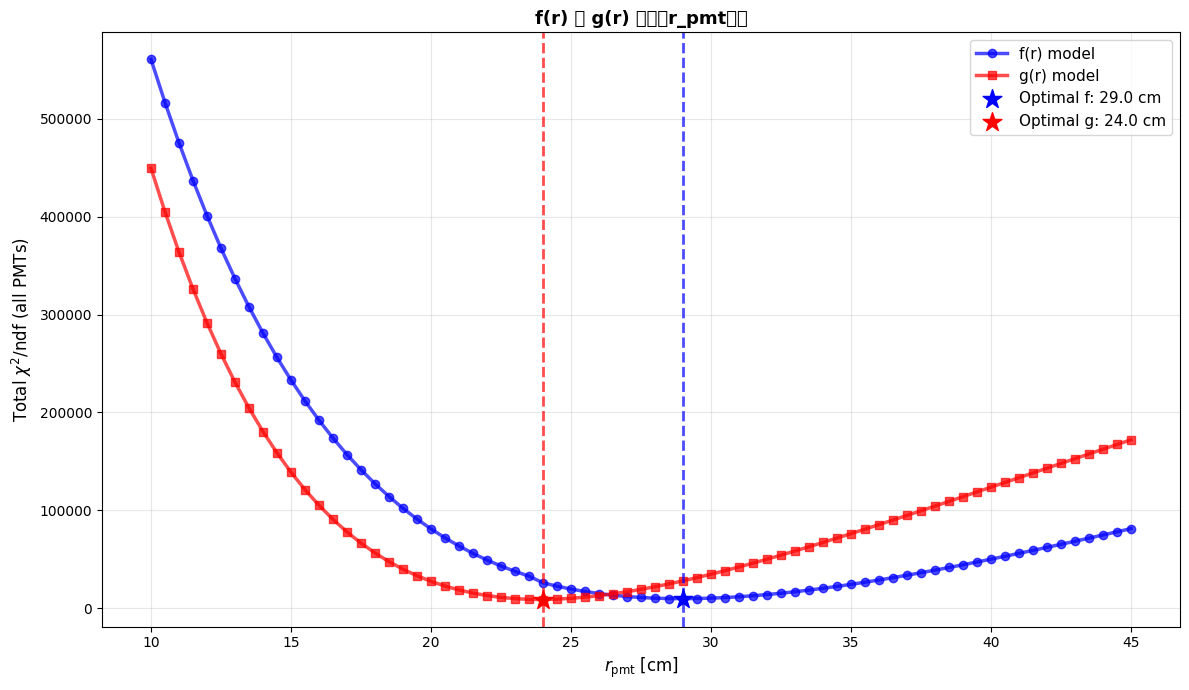


f関数での最適r_pmt = 29.0 cm の詳細解析


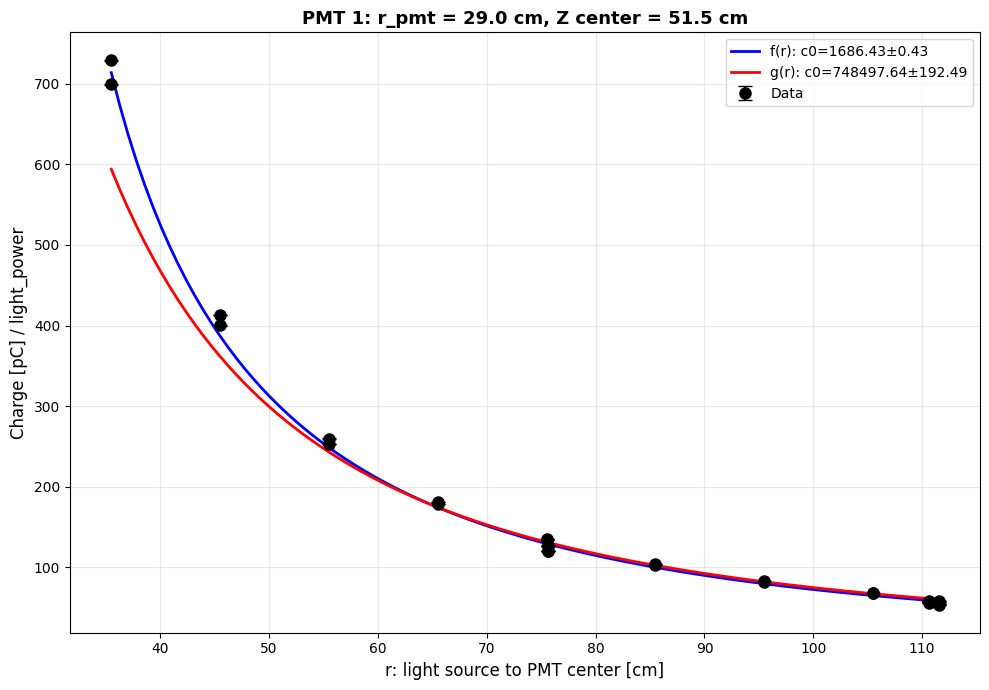

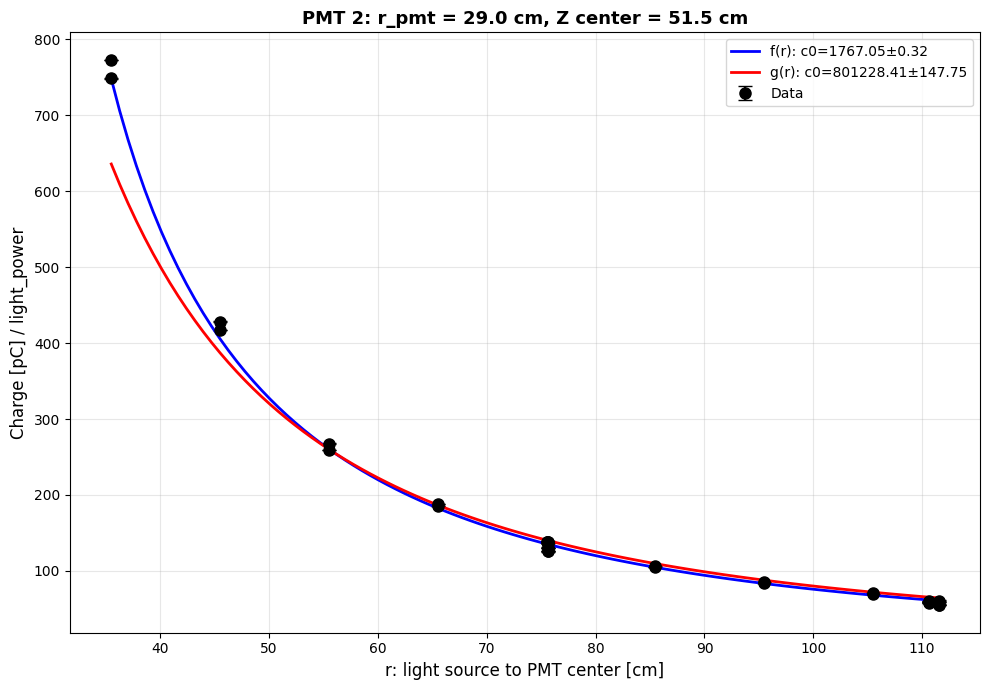

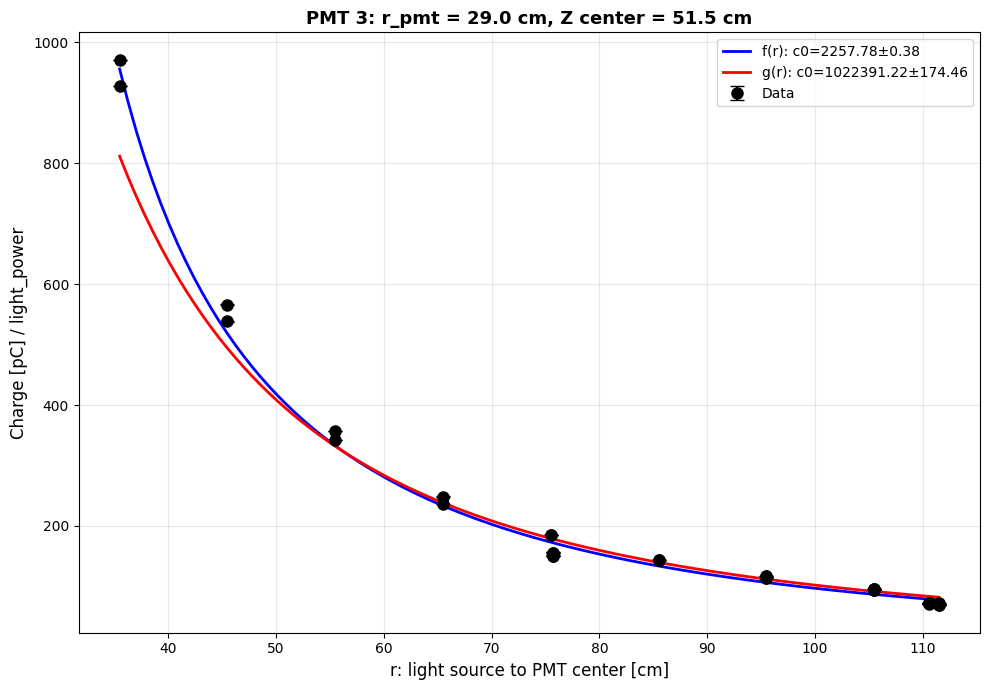

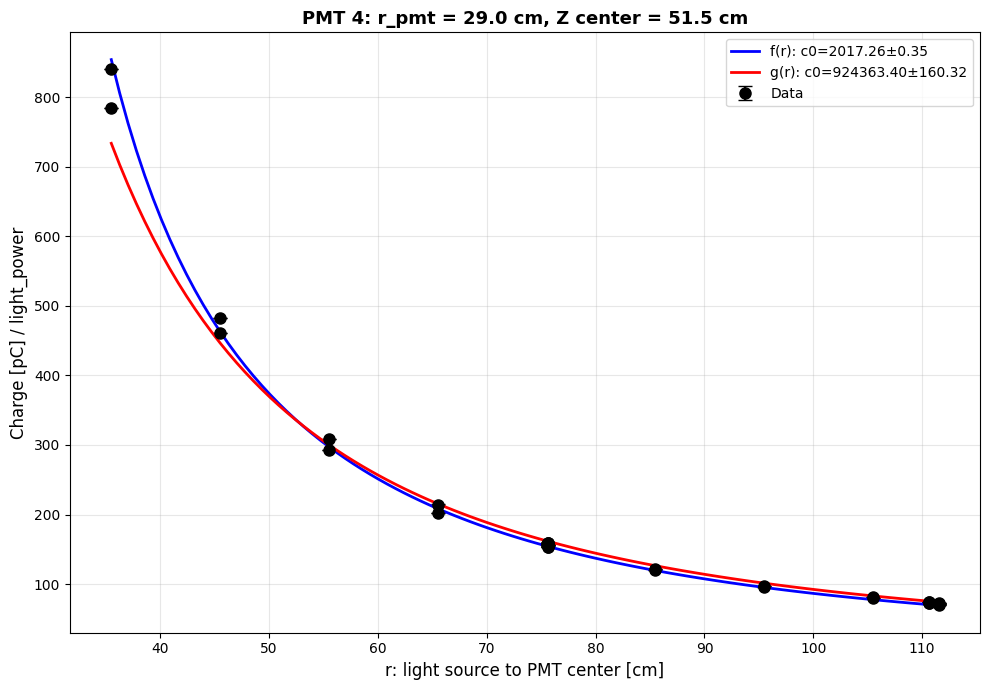


フィット結果 (r_pmt = 29.0 cm, z_center = 51.5 cm)
 PMT_num  n_data  r_pmt  z_pmt_center        f_c0  f_c0_err  f_chi2_ndf         g_c0   g_c0_err   g_chi2_ndf
       1      28   29.0          51.5 1686.432523  0.432670 1150.691856 7.484976e+05 192.487230  3796.303364
       2      32   29.0          51.5 1767.050812  0.324612 1358.436845 8.012284e+05 147.754970  8681.334816
       3      34   29.0          51.5 2257.784746  0.384065 5659.065835 1.022391e+06 174.464923 12242.251193
       4      32   29.0          51.5 2017.263074  0.349612 1569.650918 9.243634e+05 160.324212  3215.532997


g関数での最適r_pmt = 24.0 cm の詳細解析


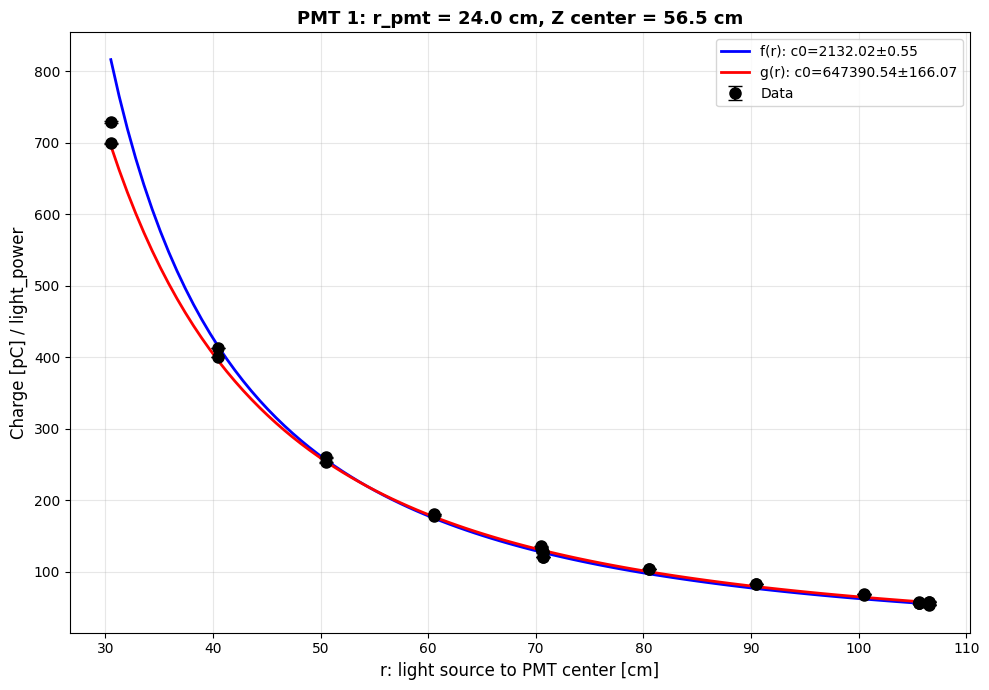

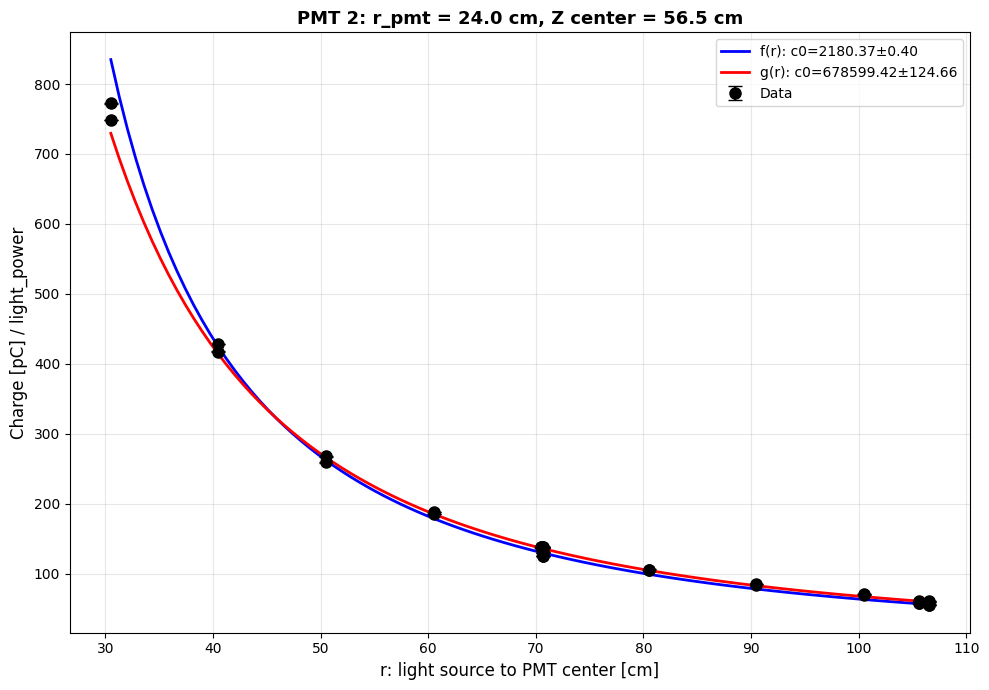

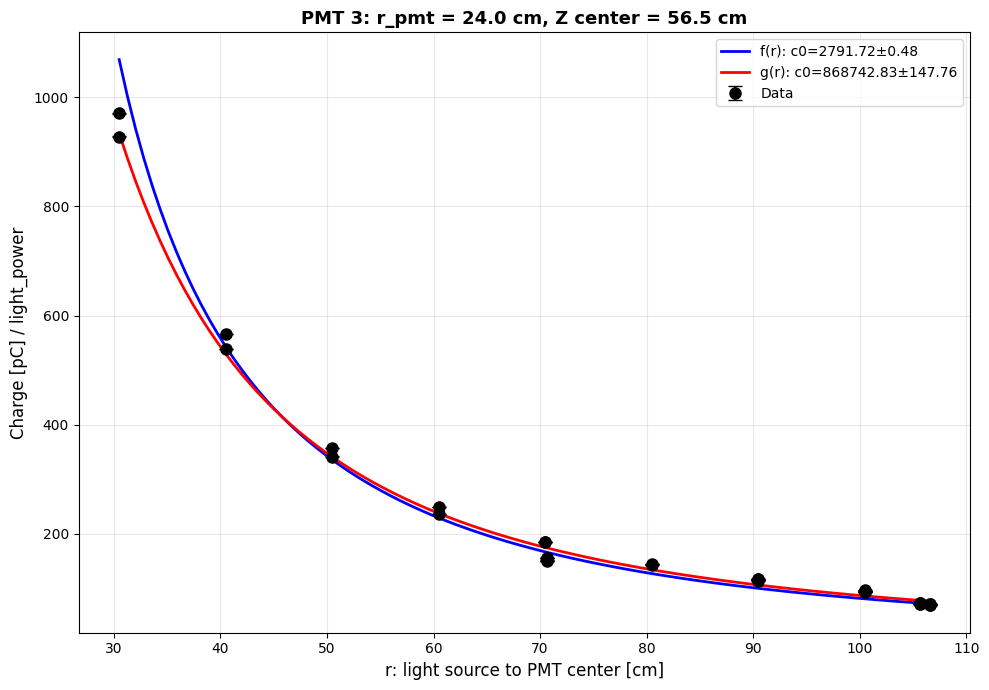

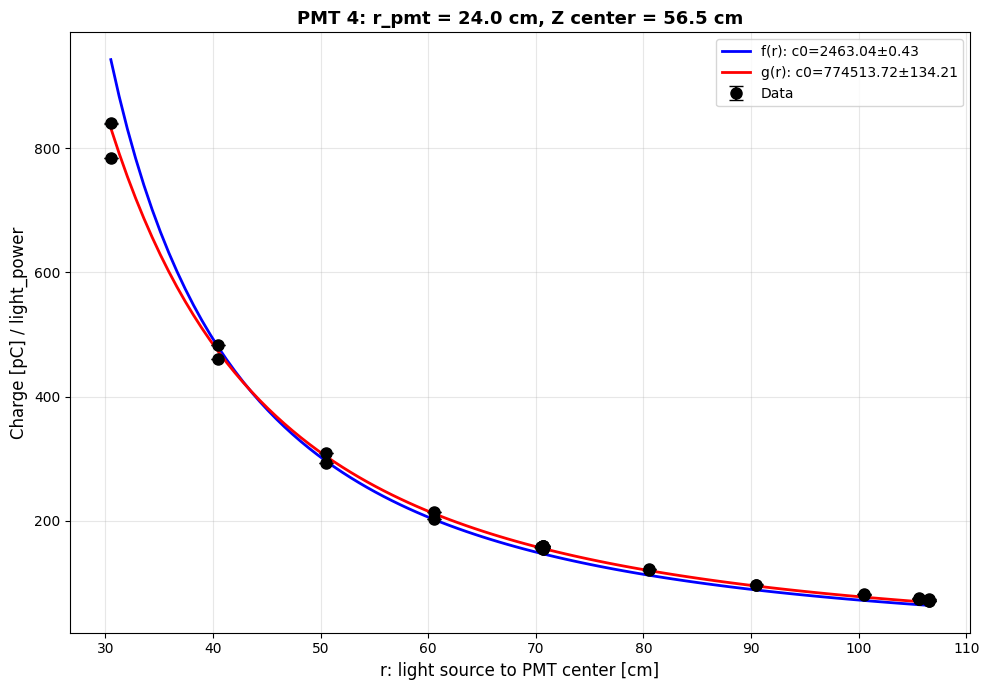


フィット結果 (r_pmt = 24.0 cm, z_center = 56.5 cm)
 PMT_num  n_data  r_pmt  z_pmt_center        f_c0  f_c0_err   f_chi2_ndf          g_c0   g_c0_err  g_chi2_ndf
       1      28   24.0          56.5 2132.023311  0.547325  1837.443742 647390.542942 166.065333  955.109254
       2      32   24.0          56.5 2180.368988  0.401011  3604.308571 678599.420934 124.657860 1316.004210
       3      34   24.0          56.5 2791.721585  0.475842  9843.129549 868742.831124 147.755759 5328.779907
       4      32   24.0          56.5 2463.041748  0.428677 10608.722147 774513.718926 134.211547 1260.158058


探索結果サマリー
f関数での最適r_pmt: 29.0 cm
g関数での最適r_pmt: 24.0 cm


In [34]:
# 最適なr_pmtを探索
optimal_r_pmt_f, results_f, fit_functions_f, \
optimal_r_pmt_g, results_g, fit_functions_g = find_optimal_r_pmt(df)

# 結果を表示
print(f"\n{'='*80}")
print(f"探索結果サマリー")
print(f"{'='*80}")
print(f"f関数での最適r_pmt: {optimal_r_pmt_f:.1f} cm")
print(f"g関数での最適r_pmt: {optimal_r_pmt_g:.1f} cm")
print(f"{'='*80}")


f関数でのε(cos α)解析 (r_pmt = 29.0 cm)



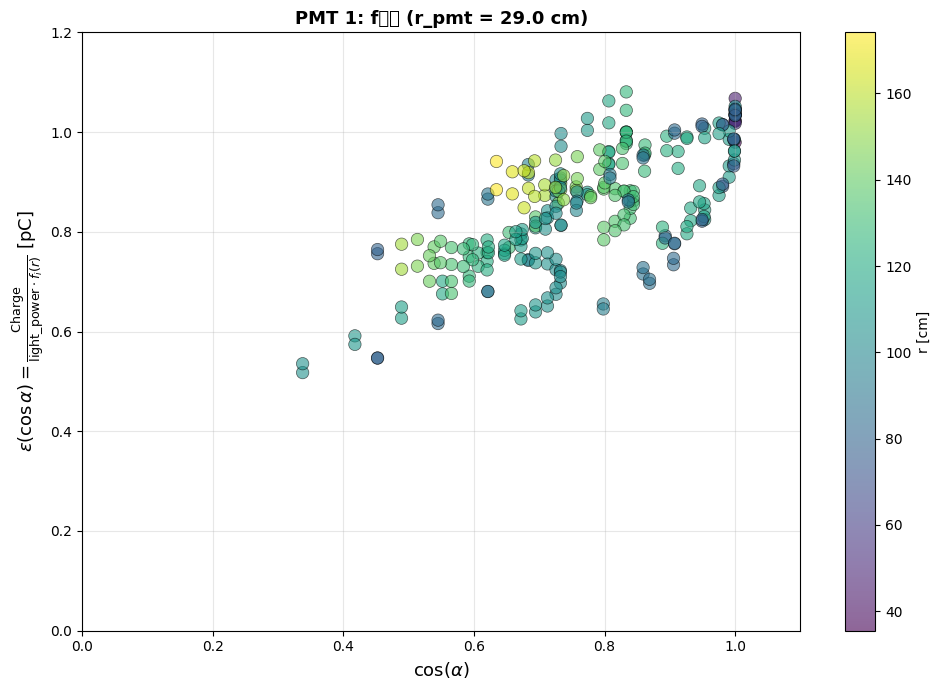

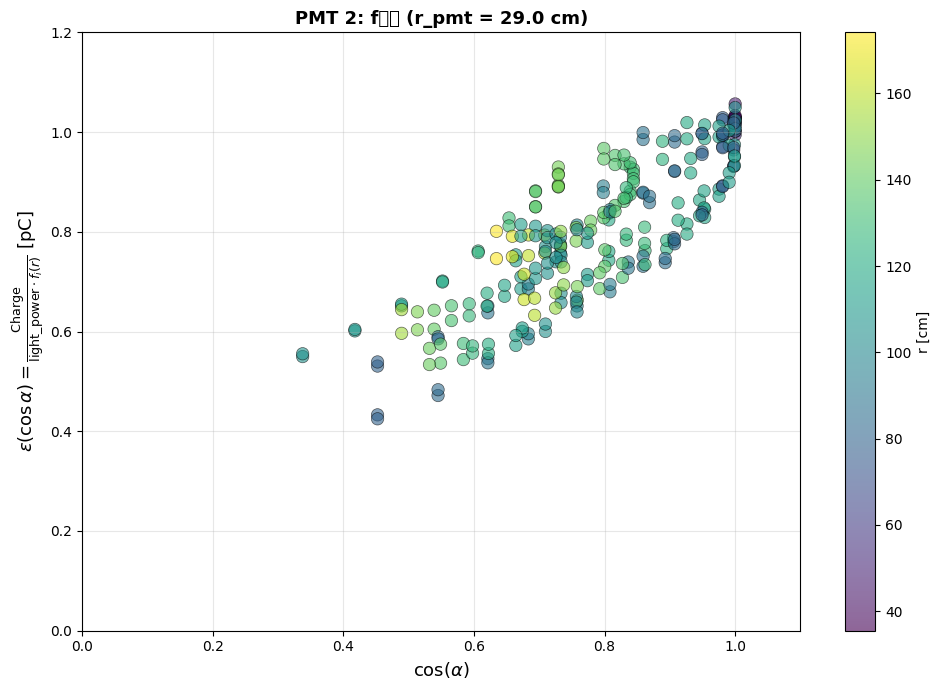

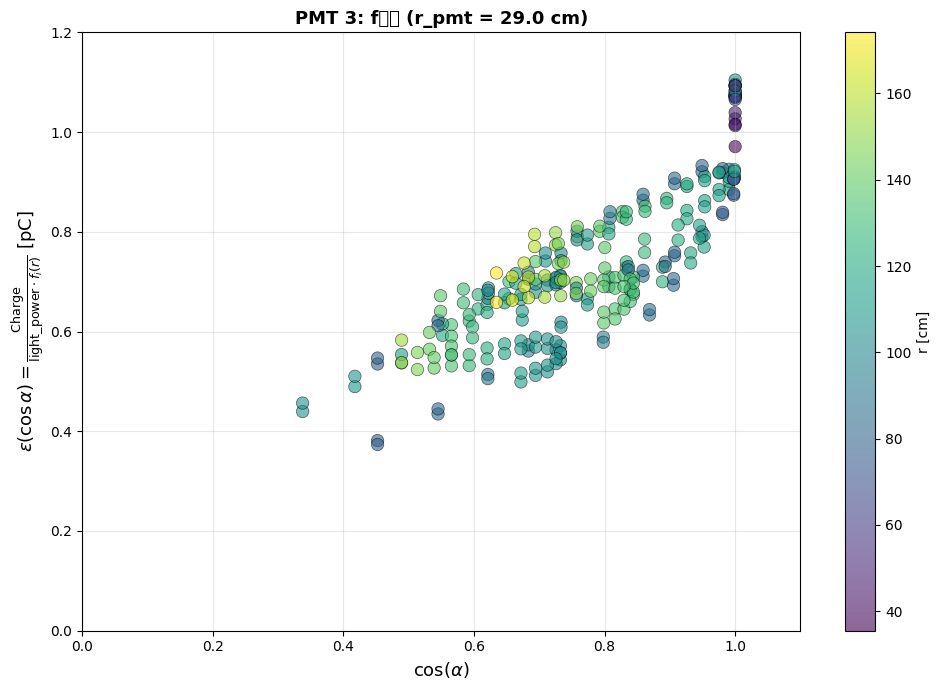

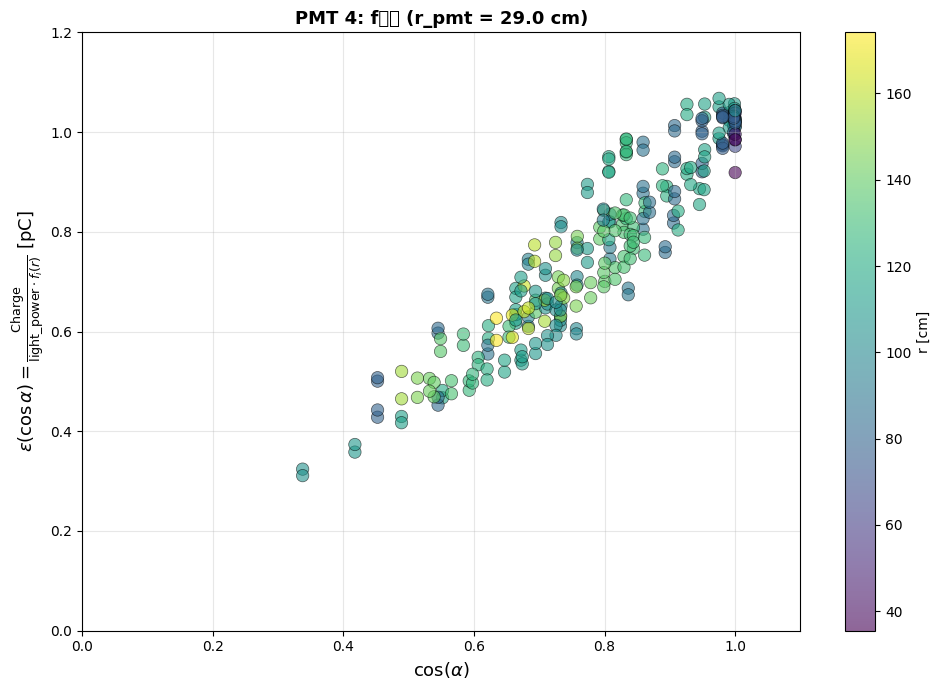

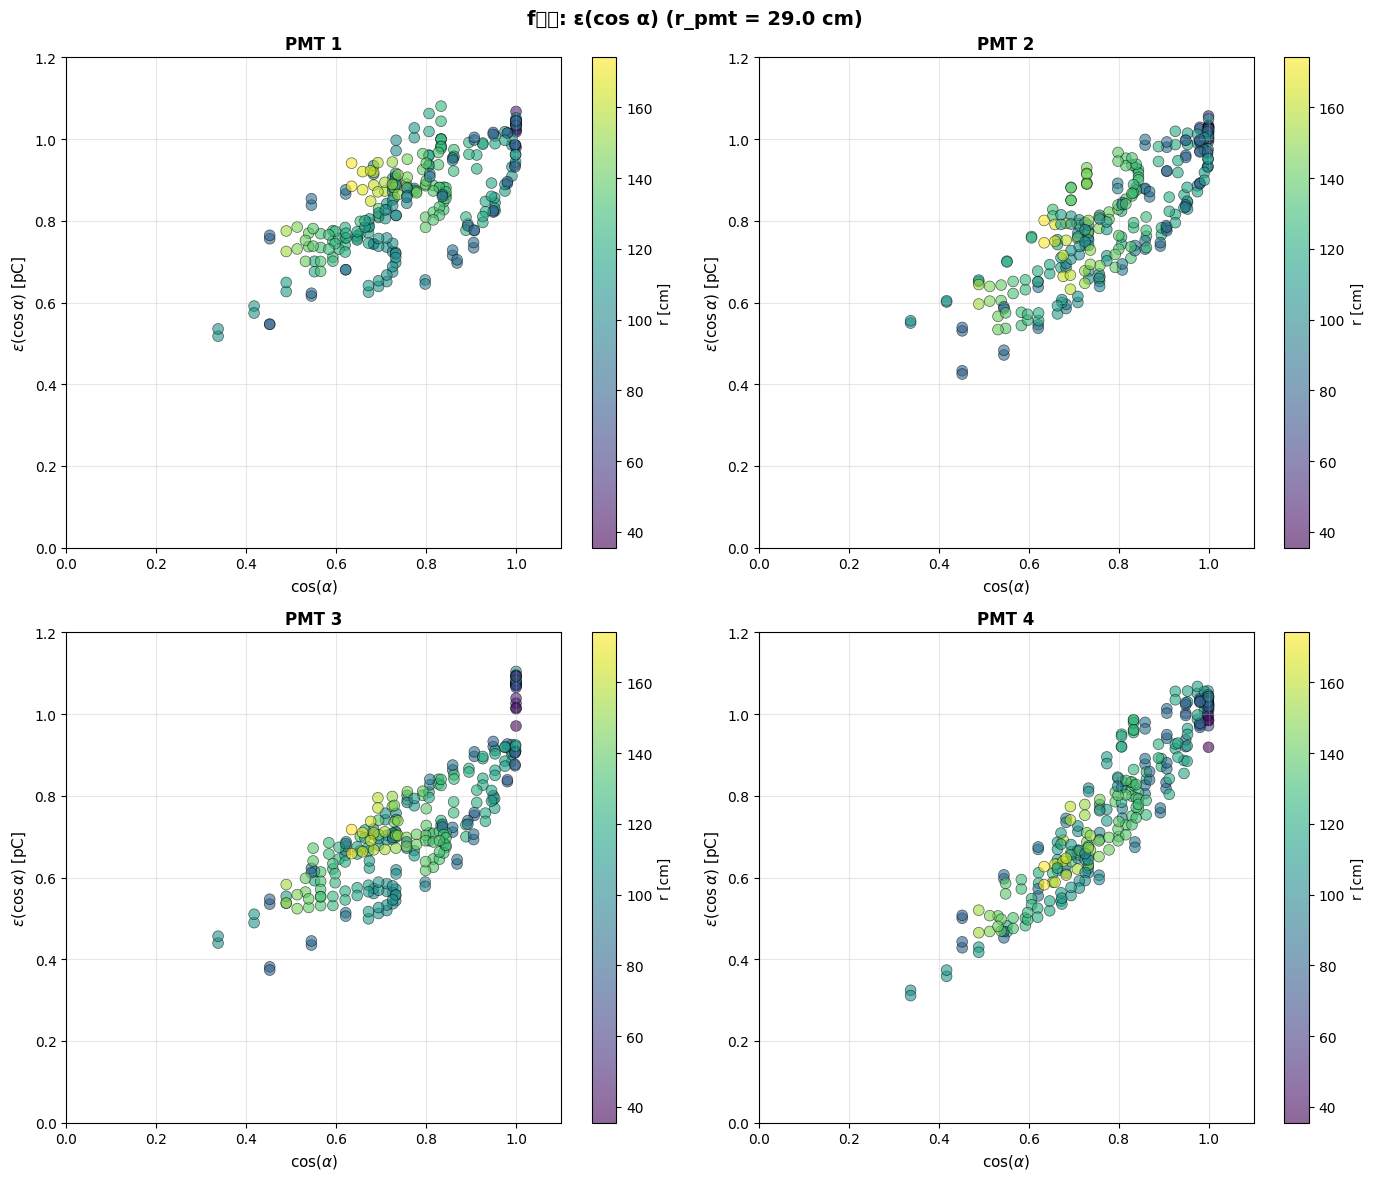


g関数でのε(cos α)解析 (r_pmt = 24.0 cm)



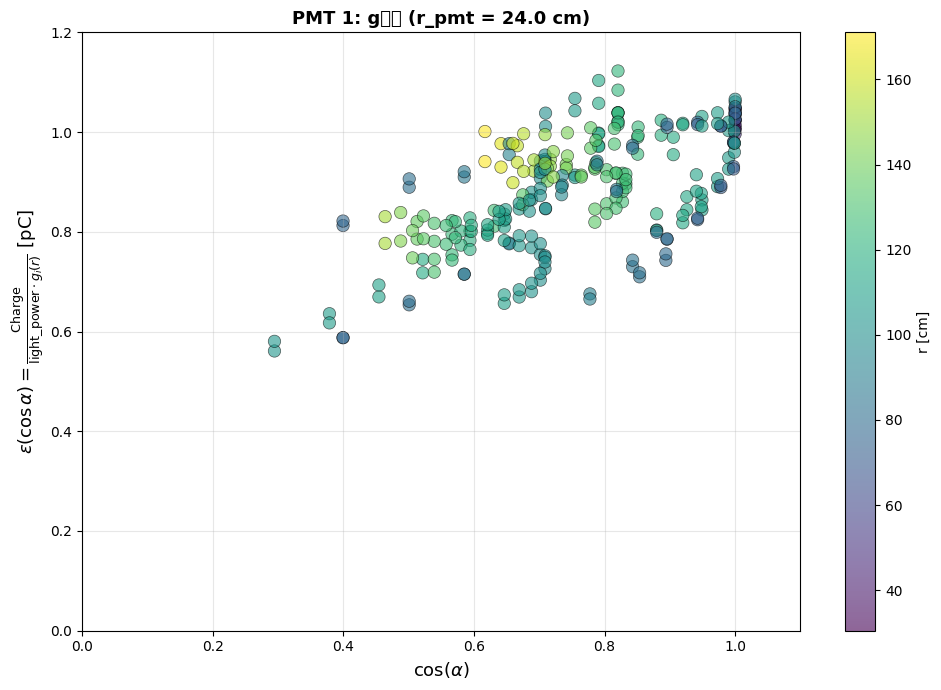

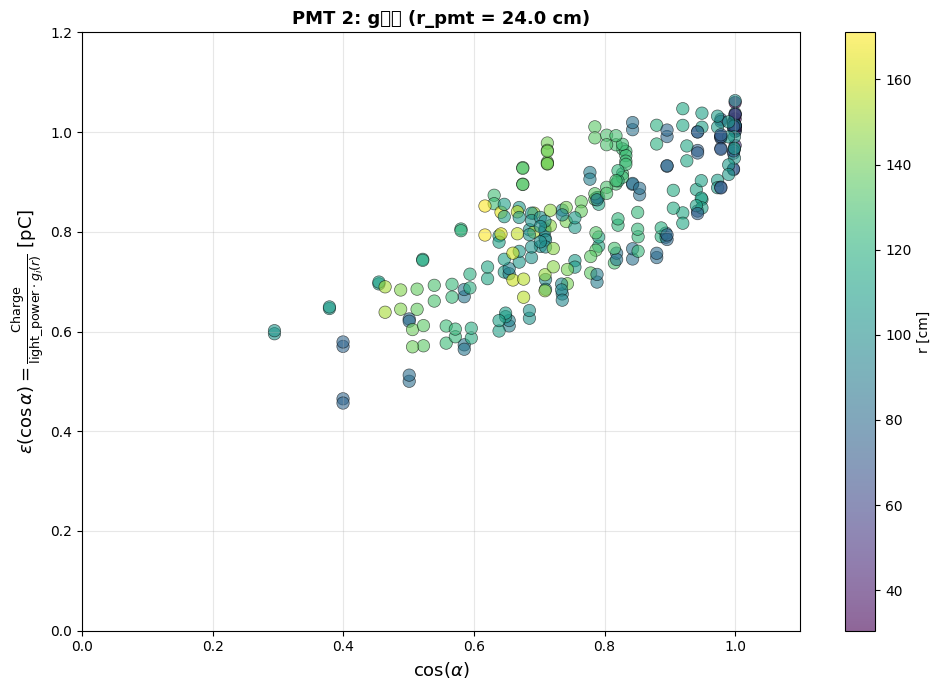

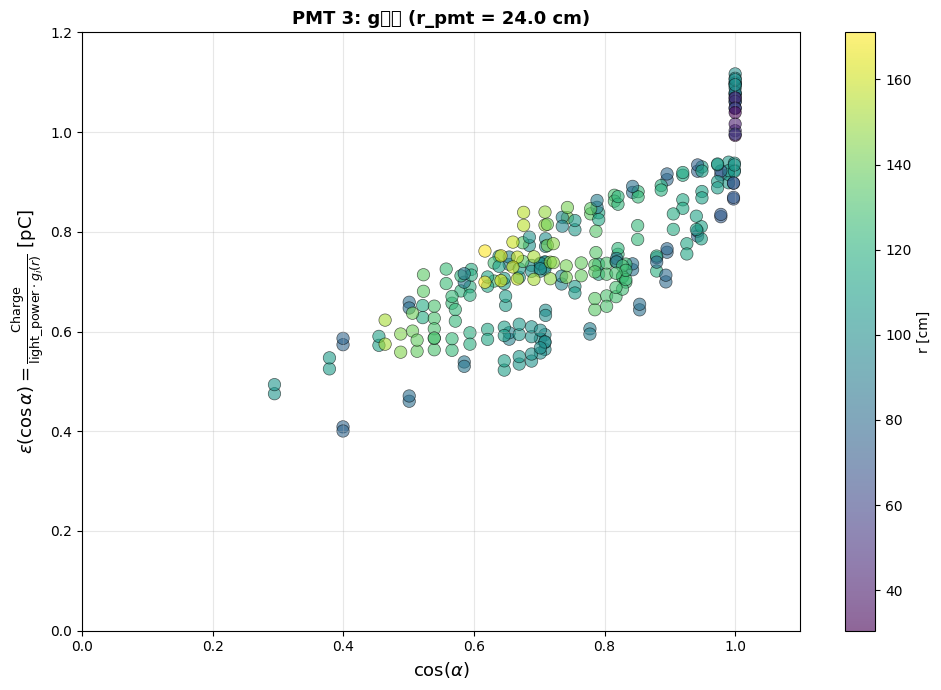

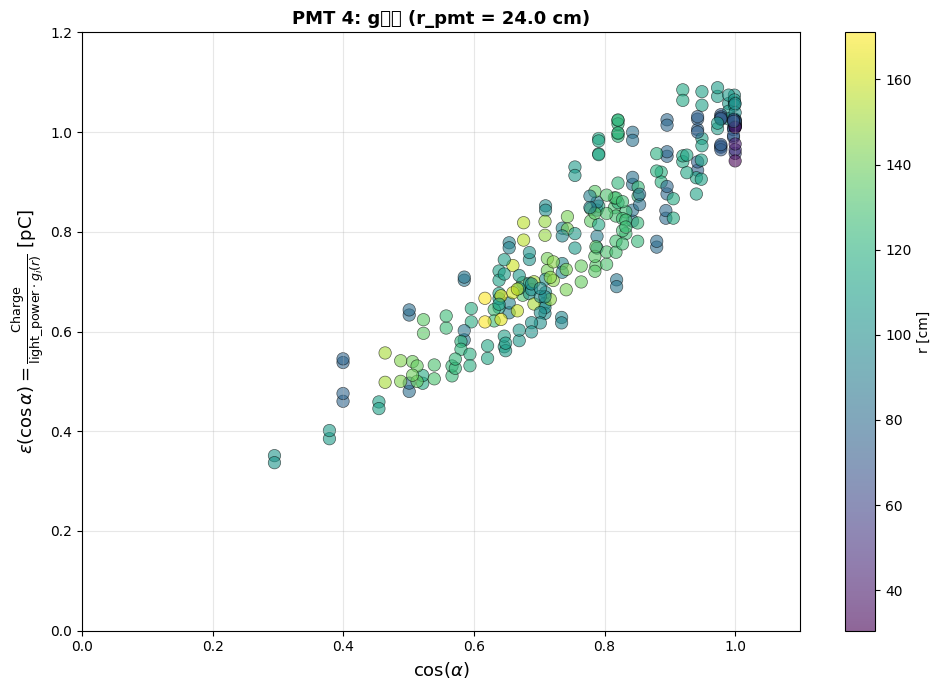

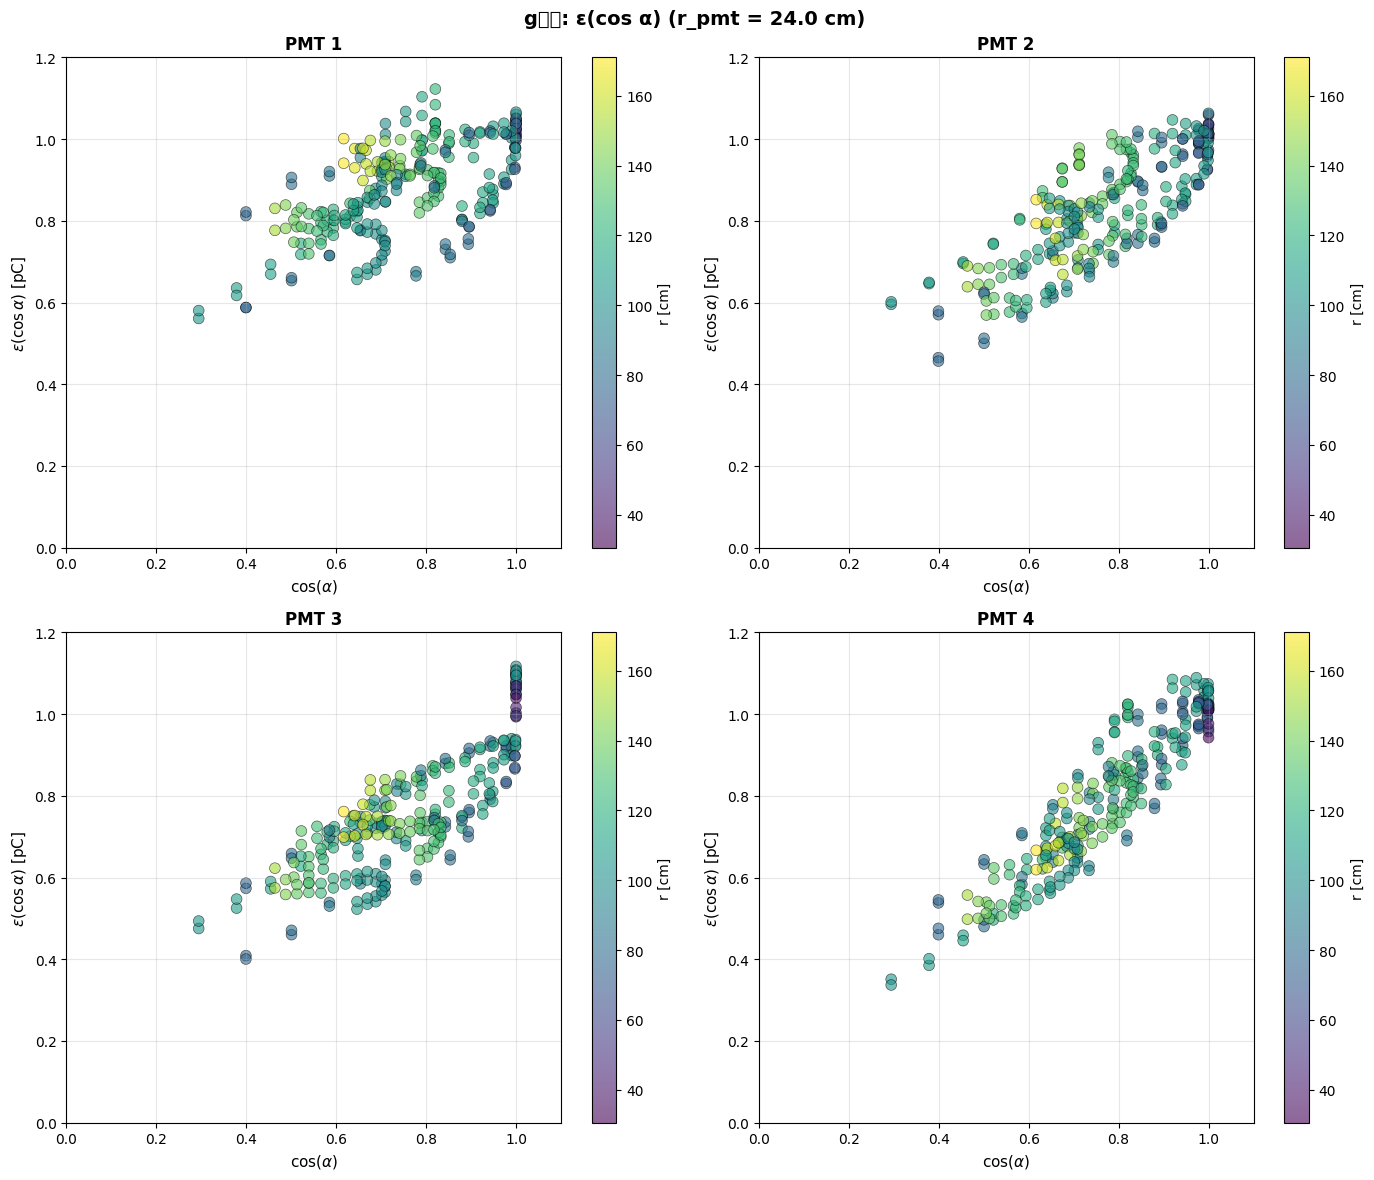


プロット完了



In [35]:
def plot_epsilon_cos_alpha(optimal_r_pmt_f, results_f, fit_functions_f,
                           optimal_r_pmt_g, results_g, fit_functions_g,
                           df, show_plots=True):
    """
    Charge/(light_power*f_i(r)) と Charge/(light_power*g_i(r)) を
    y軸に、x軸にcos(alpha)をとってプロット
    
    Parameters:
    -----------
    optimal_r_pmt_f : float
        f関数での最適r_pmt [cm]
    results_f : list
        f関数でのフィット結果
    fit_functions_f : dict
        f関数での関数オブジェクト
    optimal_r_pmt_g : float
        g関数での最適r_pmt [cm]
    results_g : list
        g関数でのフィット結果
    fit_functions_g : dict
        g関数での関数オブジェクト
    df : pandas.DataFrame
        元のデータフレーム
    show_plots : bool
        グラフを表示するか
    """
    
    PMT_COORDS = {
        1: (-35, 35),
        2: (35, 35),
        3: (-35, -35),
        4: (35, -35)
    }
    
    Z_PMT_SURFACE = 80.5
    
    # ============================================================================
    # f関数での解析
    # ============================================================================
    print(f"\n{'='*80}")
    print(f"f関数でのε(cos α)解析 (r_pmt = {optimal_r_pmt_f:.1f} cm)")
    print(f"{'='*80}\n")
    
    z_pmt_center_f = Z_PMT_SURFACE - optimal_r_pmt_f
    
    # 新しい座標系でのr と cos(alpha)を計算
    df_f = df.copy()
    df_f['r_pmt'] = np.nan
    df_f['cos_alpha_pmt'] = np.nan
    
    for pmt_num, (x_pmt, y_pmt) in PMT_COORDS.items():
        mask = df_f['#PMT_num'] == pmt_num
        dx = df_f.loc[mask, 'x'].values - x_pmt
        dy = df_f.loc[mask, 'y'].values - y_pmt
        dz = df_f.loc[mask, 'z'].values - z_pmt_center_f
        
        r = np.sqrt(dx**2 + dy**2 + dz**2)
        cos_alpha = dz / r
        
        df_f.loc[mask, 'r_pmt'] = r
        df_f.loc[mask, 'cos_alpha_pmt'] = cos_alpha
    
    # Charge/light_power の計算
    df_f['charge_normalized'] = df_f['Charge(pC)'] / df_f['light_power(def:(15dB, 5V)=1)']
    
    # f関数での epsilon = Charge / (light_power * f_i(r)) を計算
    df_f['epsilon_f'] = np.nan
    
    for pmt_num in [1, 2, 3, 4]:
        if pmt_num in fit_functions_f and 'f' in fit_functions_f[pmt_num]:
            mask = df_f['#PMT_num'] == pmt_num
            f_func = fit_functions_f[pmt_num]['f']
            r_vals = df_f.loc[mask, 'r_pmt'].values
            
            # f_i(r)を計算
            f_i_vals = f_func(r_vals)
            
            # epsilon = Charge / (light_power * f_i(r))
            df_f.loc[mask, 'epsilon_f'] = df_f.loc[mask, 'charge_normalized'].values / f_i_vals
    
    # プロット：PMTごとに4枚＋1枚まとめて図
    fig_individual_f = []
    for pmt_num in [1, 2, 3, 4]:
        pmt_data = df_f[df_f['#PMT_num'] == pmt_num].copy()
        
        ##############################################
        # コメントアウト可能なフィルター
        pmt_data = pmt_data[pmt_data['Charge(pC)'] > 0]  # 例：Charge > 5の点のみ
        
        # epsilon >= 10 の点を除外
        pmt_data = pmt_data[pmt_data['epsilon_f'] < 10]
        ##############################################
        
        pmt_data = pmt_data[pmt_data['epsilon_f'].notna()]
        
        if len(pmt_data) > 0:
            fig, ax = plt.subplots(figsize=(10, 7))
            scatter = ax.scatter(pmt_data['cos_alpha_pmt'], pmt_data['epsilon_f'], 
                      c=pmt_data['r_pmt'], cmap='viridis',
                      s=80, alpha=0.6, edgecolors='black', linewidth=0.5)
            plt.colorbar(scatter, ax=ax, label='r [cm]')
            
            ax.set_xlabel(r'$\cos(\alpha)$', fontsize=13)
            ax.set_ylabel(r'$\epsilon(\cos\alpha) = \frac{\mathrm{Charge}}{\mathrm{light\_power} \cdot f_i(r)}$ [pC]', 
                         fontsize=13)
            ax.set_title(f'PMT {pmt_num}: f関数 (r_pmt = {optimal_r_pmt_f:.1f} cm)', 
                        fontsize=13, fontweight='bold')
            ax.set_xlim(0, 1.1)
            ax.set_ylim(0, 1.2)
            ax.grid(True, alpha=0.3)
            plt.tight_layout()
            if show_plots:
                plt.show()
            fig_individual_f.append(fig)
    
    # まとめた図（2x2）
    fig_grid_f, axes = plt.subplots(2, 2, figsize=(14, 12))
    axes = axes.flatten()
    
    for pmt_num, ax in zip([1, 2, 3, 4], axes):
        pmt_data = df_f[df_f['#PMT_num'] == pmt_num].copy()
        
        ##############################################
        pmt_data = pmt_data[pmt_data['Charge(pC)'] > 0]
        pmt_data = pmt_data[pmt_data['epsilon_f'] < 10]
        ##############################################
        
        pmt_data = pmt_data[pmt_data['epsilon_f'].notna()]
        
        if len(pmt_data) > 0:
            scatter = ax.scatter(pmt_data['cos_alpha_pmt'], pmt_data['epsilon_f'], 
                      c=pmt_data['r_pmt'], cmap='viridis',
                      s=60, alpha=0.6, edgecolors='black', linewidth=0.5)
            plt.colorbar(scatter, ax=ax, label='r [cm]')
            
            ax.set_xlabel(r'$\cos(\alpha)$', fontsize=11)
            ax.set_ylabel(r'$\epsilon(\cos\alpha)$ [pC]', fontsize=11)
            ax.set_title(f'PMT {pmt_num}', fontsize=12, fontweight='bold')
            ax.set_xlim(0, 1.1)
            ax.set_ylim(0, 1.2)
            ax.grid(True, alpha=0.3)
    
    fig_grid_f.suptitle(f'f関数: ε(cos α) (r_pmt = {optimal_r_pmt_f:.1f} cm)', 
                       fontsize=14, fontweight='bold')
    plt.tight_layout()
    if show_plots:
        plt.show()
    
    # ============================================================================
    # g関数での解析
    # ============================================================================
    print(f"\n{'='*80}")
    print(f"g関数でのε(cos α)解析 (r_pmt = {optimal_r_pmt_g:.1f} cm)")
    print(f"{'='*80}\n")
    
    z_pmt_center_g = Z_PMT_SURFACE - optimal_r_pmt_g
    
    # 新しい座標系でのr と cos(alpha)を計算
    df_g = df.copy()
    df_g['r_pmt'] = np.nan
    df_g['cos_alpha_pmt'] = np.nan
    
    for pmt_num, (x_pmt, y_pmt) in PMT_COORDS.items():
        mask = df_g['#PMT_num'] == pmt_num
        dx = df_g.loc[mask, 'x'].values - x_pmt
        dy = df_g.loc[mask, 'y'].values - y_pmt
        dz = df_g.loc[mask, 'z'].values - z_pmt_center_g
        
        r = np.sqrt(dx**2 + dy**2 + dz**2)
        cos_alpha = dz / r
        
        df_g.loc[mask, 'r_pmt'] = r
        df_g.loc[mask, 'cos_alpha_pmt'] = cos_alpha
    
    # Charge/light_power の計算
    df_g['charge_normalized'] = df_g['Charge(pC)'] / df_g['light_power(def:(15dB, 5V)=1)']
    
    # g関数での epsilon = Charge / (light_power * g_i(r)) を計算
    df_g['epsilon_g'] = np.nan
    
    for pmt_num in [1, 2, 3, 4]:
        if pmt_num in fit_functions_g and 'g' in fit_functions_g[pmt_num]:
            mask = df_g['#PMT_num'] == pmt_num
            g_func = fit_functions_g[pmt_num]['g']
            r_vals = df_g.loc[mask, 'r_pmt'].values
            
            # g_i(r)を計算
            g_i_vals = g_func(r_vals)
            
            # epsilon = Charge / (light_power * g_i(r))
            df_g.loc[mask, 'epsilon_g'] = df_g.loc[mask, 'charge_normalized'].values / g_i_vals
    
    # プロット：PMTごとに4枚＋1枚まとめて図
    fig_individual_g = []
    for pmt_num in [1, 2, 3, 4]:
        pmt_data = df_g[df_g['#PMT_num'] == pmt_num].copy()
        
        ##############################################
        # コメントアウト可能なフィルター
        pmt_data = pmt_data[pmt_data['Charge(pC)'] > 0]  # 例：Charge > 0の点のみ
        
        # epsilon >= 10 の点を除外
        pmt_data = pmt_data[pmt_data['epsilon_g'] < 10]
        ##############################################
        
        pmt_data = pmt_data[pmt_data['epsilon_g'].notna()]
        
        if len(pmt_data) > 0:
            fig, ax = plt.subplots(figsize=(10, 7))
            scatter = ax.scatter(pmt_data['cos_alpha_pmt'], pmt_data['epsilon_g'], 
                      c=pmt_data['r_pmt'], cmap='viridis',
                      s=80, alpha=0.6, edgecolors='black', linewidth=0.5)
            plt.colorbar(scatter, ax=ax, label='r [cm]')
            
            ax.set_xlabel(r'$\cos(\alpha)$', fontsize=13)
            ax.set_ylabel(r'$\epsilon(\cos\alpha) = \frac{\mathrm{Charge}}{\mathrm{light\_power} \cdot g_i(r)}$ [pC]', 
                         fontsize=13)
            ax.set_title(f'PMT {pmt_num}: g関数 (r_pmt = {optimal_r_pmt_g:.1f} cm)', 
                        fontsize=13, fontweight='bold')
            ax.set_xlim(0, 1.1)
            ax.set_ylim(0, 1.2)
            ax.grid(True, alpha=0.3)
            plt.tight_layout()
            if show_plots:
                plt.show()
            fig_individual_g.append(fig)
    
    # まとめた図（2x2）
    fig_grid_g, axes = plt.subplots(2, 2, figsize=(14, 12))
    axes = axes.flatten()
    
    for pmt_num, ax in zip([1, 2, 3, 4], axes):
        pmt_data = df_g[df_g['#PMT_num'] == pmt_num].copy()
        
        ##############################################
        pmt_data = pmt_data[pmt_data['Charge(pC)'] > 0]
        
        # epsilon >= 10 の点を除外
        pmt_data = pmt_data[pmt_data['epsilon_g'] < 10]
        ##############################################
        
        pmt_data = pmt_data[pmt_data['epsilon_g'].notna()]
        
        if len(pmt_data) > 0:
            scatter = ax.scatter(pmt_data['cos_alpha_pmt'], pmt_data['epsilon_g'], 
                      c=pmt_data['r_pmt'], cmap='viridis',
                      s=60, alpha=0.6, edgecolors='black', linewidth=0.5)
            plt.colorbar(scatter, ax=ax, label='r [cm]')
            
            ax.set_xlabel(r'$\cos(\alpha)$', fontsize=11)
            ax.set_ylabel(r'$\epsilon(\cos\alpha)$ [pC]', fontsize=11)
            ax.set_title(f'PMT {pmt_num}', fontsize=12, fontweight='bold')
            ax.set_xlim(0, 1.1)
            ax.set_ylim(0, 1.2)
            ax.grid(True, alpha=0.3)
    
    fig_grid_g.suptitle(f'g関数: ε(cos α) (r_pmt = {optimal_r_pmt_g:.1f} cm)', 
                       fontsize=14, fontweight='bold')
    plt.tight_layout()
    if show_plots:
        plt.show()
    
    print(f"\n{'='*80}")
    print(f"プロット完了")
    print(f"{'='*80}\n")


# 実行
plot_epsilon_cos_alpha(optimal_r_pmt_f, results_f, fit_functions_f,
                       optimal_r_pmt_g, results_g, fit_functions_g,
                       df, show_plots=True)

In [36]:
def fit_epsilon_polynomial(cos_alpha_data, epsilon_data, epsilon_err_data, 
                          model_type='f', pmt_num=None, method='A'):
    """
    epsilon(cos(alpha)) を7次多項式で近似（制約: cos(alpha)=1で epsilon=1）
    
    Parameters:
    -----------
    cos_alpha_data : array
        cos(alpha)の値
    epsilon_data : array
        epsilon = Charge/(light_power*f_i(r)) の値
    epsilon_err_data : array
        epsilonの誤差
    model_type : str
        'f' または 'g'
    pmt_num : int
        PMT番号（テーブル出力用）
    method : str
        'A': 制約を事後適用（8パラメータ）
        'B': 再パラメータ化（7パラメータ）
    
    Returns:
    --------
    result : dict
        フィッティング結果
    poly_func : function
        多項式関数
    """
    
    if method == 'A':
        # ============================================================================
        # 方法A：8個のパラメータで直接フィッティング → 事後制約適用
        # ============================================================================
        def poly_model_8(x, c0, c1, c2, c3, c4, c5, c6, c7):
            """8次項まで（但し7次多項式）"""
            return c0 + c1*x + c2*x**2 + c3*x**3 + c4*x**4 + c5*x**5 + c6*x**6 + c7*x**7
        
        try:
            # フィッティング実行
            popt, pcov = curve_fit(
                poly_model_8,
                cos_alpha_data, epsilon_data,
                sigma=epsilon_err_data,
                absolute_sigma=True,
                maxfev=5000
            )
            
            # 制約を強制適用：c0 = 1 - (c1 + ... + c7)
            c_vals = list(popt)
            c0_original = c_vals[0]
            c0_constrained = 1.0 - sum(c_vals[1:])
            
            # c0の誤差：Δc0 = sqrt(Δc1² + ... + Δc7²)（独立）
            perr = np.sqrt(np.diag(pcov))
            c0_err_constrained = np.sqrt(np.sum(perr[1:]**2))
            
            # 修正後のパラメータで予測
            c_vals[0] = c0_constrained
            y_pred = poly_model_8(cos_alpha_data, *c_vals)
            
            # Chi2計算
            residuals = (epsilon_data - y_pred) / epsilon_err_data
            chi2 = np.sum(residuals**2)
            ndf = len(epsilon_data) - 7  # 7個の独立パラメータ
            chi2_ndf = chi2 / ndf if ndf > 0 else np.inf
            
            result = {
                'success': True,
                'model': model_type,
                'pmt': pmt_num,
                'method': 'A',
                'c0': c0_constrained,
                'c0_err': c0_err_constrained,
                'c1': c_vals[1], 'c1_err': perr[1],
                'c2': c_vals[2], 'c2_err': perr[2],
                'c3': c_vals[3], 'c3_err': perr[3],
                'c4': c_vals[4], 'c4_err': perr[4],
                'c5': c_vals[5], 'c5_err': perr[5],
                'c6': c_vals[6], 'c6_err': perr[6],
                'c7': c_vals[7], 'c7_err': perr[7],
                'chi2': chi2,
                'ndf': ndf,
                'chi2_ndf': chi2_ndf,
                'n_points': len(epsilon_data),
                'constraint_sum': sum(c_vals)  # 検証用：1.0になるはず
            }
            
            def poly_func_a(x):
                return c0_constrained + c_vals[1]*x + c_vals[2]*x**2 + c_vals[3]*x**3 + \
                       c_vals[4]*x**4 + c_vals[5]*x**5 + c_vals[6]*x**6 + c_vals[7]*x**7
            
            return result, poly_func_a
            
        except Exception as e:
            print(f"  フィッティング失敗 (方法A): {e}")
            return None, None
    
    elif method == 'B':
        # ============================================================================
        # 方法B：再パラメータ化（7個のパラメータ）
        # ============================================================================
        def poly_model_7(x, c1, c2, c3, c4, c5, c6, c7):
            """制約付き7次多項式：ε = 1 + c1*(x-1) + c2*(x²-1) + ... + c7*(x⁷-1)"""
            return (1.0 + c1*(x - 1) + c2*(x**2 - 1) + c3*(x**3 - 1) + 
                    c4*(x**4 - 1) + c5*(x**5 - 1) + c6*(x**6 - 1) + c7*(x**7 - 1))
        
        try:
            # フィッティング実行
            popt, pcov = curve_fit(
                poly_model_7,
                cos_alpha_data, epsilon_data,
                sigma=epsilon_err_data,
                absolute_sigma=True,
                maxfev=5000
            )
            
            # c0 = 1 - (c1 + ... + c7)、誤差：Δc0 = sqrt(Δc1² + ... + Δc7²)
            c0_val = 1.0 - np.sum(popt)
            perr = np.sqrt(np.diag(pcov))
            c0_err = np.sqrt(np.sum(perr**2))
            
            # Chi2計算
            y_pred = poly_model_7(cos_alpha_data, *popt)
            residuals = (epsilon_data - y_pred) / epsilon_err_data
            chi2 = np.sum(residuals**2)
            ndf = len(epsilon_data) - 7
            chi2_ndf = chi2 / ndf if ndf > 0 else np.inf
            
            result = {
                'success': True,
                'model': model_type,
                'pmt': pmt_num,
                'method': 'B',
                'c0': c0_val,
                'c0_err': c0_err,
                'c1': popt[0], 'c1_err': perr[0],
                'c2': popt[1], 'c2_err': perr[1],
                'c3': popt[2], 'c3_err': perr[2],
                'c4': popt[3], 'c4_err': perr[3],
                'c5': popt[4], 'c5_err': perr[4],
                'c6': popt[5], 'c6_err': perr[5],
                'c7': popt[6], 'c7_err': perr[6],
                'chi2': chi2,
                'ndf': ndf,
                'chi2_ndf': chi2_ndf,
                'n_points': len(epsilon_data),
                'constraint_sum': c0_val + sum(popt)  # 検証用：1.0になるはず
            }
            
            def poly_func_b(x):
                return (1.0 + popt[0]*(x - 1) + popt[1]*(x**2 - 1) + popt[2]*(x**3 - 1) + 
                        popt[3]*(x**4 - 1) + popt[4]*(x**5 - 1) + popt[5]*(x**6 - 1) + popt[6]*(x**7 - 1))
            
            return result, poly_func_b
            
        except Exception as e:
            print(f"  フィッティング失敗 (方法B): {e}")
            return None, None
    
    else:
        raise ValueError("method は 'A' または 'B' を指定してください")


print("✓ fit_epsilon_polynomial 関数が定義されました（方法A, B両対応）")

✓ fit_epsilon_polynomial 関数が定義されました（方法A, B両対応）


In [37]:
# ============================================================================
# 7次多項式フィッティング実行
# ============================================================================

PMT_COORDS = {
    1: (-35, 35),
    2: (35, 35),
    3: (-35, -35),
    4: (35, -35)
}

Z_PMT_SURFACE = 80.5

# f関数でのフィッティング結果を格納
poly_fit_results_f = {}
poly_fit_results_g = {}

print(f"\n{'='*100}")
print(f"7次多項式フィッティング：方法A（制約事後適用）")
print(f"{'='*100}\n")

# ============================================================================
# f関数：PMTごとのフィッティング
# ============================================================================
print(f"\n{'-'*100}")
print(f"f関数：PMTごとのフィッティング")
print(f"{'-'*100}\n")

z_pmt_center_f = Z_PMT_SURFACE - optimal_r_pmt_f

# 新しい座標系でのr と cos(alpha)を計算
df_f = df.copy()
df_f['r_pmt'] = np.nan
df_f['cos_alpha_pmt'] = np.nan

for pmt_num, (x_pmt, y_pmt) in PMT_COORDS.items():
    mask = df_f['#PMT_num'] == pmt_num
    dx = df_f.loc[mask, 'x'].values - x_pmt
    dy = df_f.loc[mask, 'y'].values - y_pmt
    dz = df_f.loc[mask, 'z'].values - z_pmt_center_f
    
    r = np.sqrt(dx**2 + dy**2 + dz**2)
    cos_alpha = dz / r
    
    df_f.loc[mask, 'r_pmt'] = r
    df_f.loc[mask, 'cos_alpha_pmt'] = cos_alpha

# Charge/light_power の計算
df_f['charge_normalized'] = df_f['Charge(pC)'] / df_f['light_power(def:(15dB, 5V)=1)']

# f関数での epsilon を計算
df_f['epsilon_f'] = np.nan
df_f['epsilon_f_err'] = np.nan

for pmt_num in [1, 2, 3, 4]:
    if pmt_num in fit_functions_f and 'f' in fit_functions_f[pmt_num]:
        mask = df_f['#PMT_num'] == pmt_num
        f_func = fit_functions_f[pmt_num]['f']
        r_vals = df_f.loc[mask, 'r_pmt'].values
        
        # f_i(r)を計算
        f_i_vals = f_func(r_vals)
        
        # epsilon = Charge / (light_power * f_i(r))
        charge_normalized = df_f.loc[mask, 'charge_normalized'].values
        charge_normalized_err = df_f.loc[mask, 'Charge_err(pC)'].values / \
                                df_f.loc[mask, 'light_power(def:(15dB, 5V)=1)'].values
        
        epsilon_vals = charge_normalized / f_i_vals
        df_f.loc[mask, 'epsilon_f'] = epsilon_vals
        
        # Jacobian法で誤差を計算
        # Δf_i = |∂f/∂c0| × Δc0 = |1 - sqrt(1 - (r_pmt/r)²)| × Δc0
        # results_fから c0_err を取得
        c0_err_f = results_f[0]['f_c0_err']  # PMT 1の例（全PMTで同じはず）
        
        deriv_f = np.abs(1.0 - np.sqrt(1.0 - (optimal_r_pmt_f/r_vals)**2))
        delta_f_i = deriv_f * c0_err_f
        
        # ε の誤差
        delta_epsilon_f = epsilon_vals * np.sqrt((charge_normalized_err/charge_normalized)**2 + 
                                                  (delta_f_i/f_i_vals)**2)
        df_f.loc[mask, 'epsilon_f_err'] = delta_epsilon_f

# PMTごとにフィッティング
for pmt_num in [1, 2, 3, 4]:
    pmt_data = df_f[df_f['#PMT_num'] == pmt_num].copy()
    
    # フィルター適用
    pmt_data = pmt_data[pmt_data['Charge(pC)'] > 0]
    pmt_data = pmt_data[pmt_data['epsilon_f'] < 10]
    pmt_data = pmt_data[pmt_data['epsilon_f'].notna()]
    
    if len(pmt_data) > 7:  # パラメータ数より多い必要がある
        cos_alpha = pmt_data['cos_alpha_pmt'].values
        epsilon = pmt_data['epsilon_f'].values
        epsilon_err = pmt_data['epsilon_f_err'].values
        
        result, poly_func = fit_epsilon_polynomial(
            cos_alpha, epsilon, epsilon_err,
            model_type='f', pmt_num=pmt_num, method='A'
        )
        
        if result is not None:
            poly_fit_results_f[pmt_num] = result
            
            print(f"PMT {pmt_num} (f関数):")
            print(f"  n_points: {result['n_points']}")
            print(f"  chi2/ndf: {result['chi2_ndf']:.6f}")
            print(f"  c0 = {result['c0']:.6f} ± {result['c0_err']:.6e}")
            print(f"  Σcᵢ = {result['constraint_sum']:.6f} (1.0になるはず)")
            print()

# 全PMTを統合したフィッティング
print(f"\nf関数：全PMT統合フィッティング")
df_f_all = df_f[df_f['Charge(pC)'] > 0].copy()
df_f_all = df_f_all[df_f_all['epsilon_f'] < 10].copy()
df_f_all = df_f_all[df_f_all['epsilon_f'].notna()].copy()

if len(df_f_all) > 7:
    cos_alpha_all = df_f_all['cos_alpha_pmt'].values
    epsilon_all = df_f_all['epsilon_f'].values
    epsilon_err_all = df_f_all['epsilon_f_err'].values
    
    result_all_f, poly_func_all_f = fit_epsilon_polynomial(
        cos_alpha_all, epsilon_all, epsilon_err_all,
        model_type='f', pmt_num='ALL', method='A'
    )
    
    if result_all_f is not None:
        poly_fit_results_f['ALL'] = result_all_f
        print(f"全PMT (f関数):")
        print(f"  n_points: {result_all_f['n_points']}")
        print(f"  chi2/ndf: {result_all_f['chi2_ndf']:.6f}")
        print(f"  c0 = {result_all_f['c0']:.6f} ± {result_all_f['c0_err']:.6e}")
        print(f"  Σcᵢ = {result_all_f['constraint_sum']:.6f}")

# ============================================================================
# g関数：同様の処理
# ============================================================================
print(f"\n{'-'*100}")
print(f"g関数：PMTごとのフィッティング")
print(f"{'-'*100}\n")

z_pmt_center_g = Z_PMT_SURFACE - optimal_r_pmt_g

df_g = df.copy()
df_g['r_pmt'] = np.nan
df_g['cos_alpha_pmt'] = np.nan

for pmt_num, (x_pmt, y_pmt) in PMT_COORDS.items():
    mask = df_g['#PMT_num'] == pmt_num
    dx = df_g.loc[mask, 'x'].values - x_pmt
    dy = df_g.loc[mask, 'y'].values - y_pmt
    dz = df_g.loc[mask, 'z'].values - z_pmt_center_g
    
    r = np.sqrt(dx**2 + dy**2 + dz**2)
    cos_alpha = dz / r
    
    df_g.loc[mask, 'r_pmt'] = r
    df_g.loc[mask, 'cos_alpha_pmt'] = cos_alpha

df_g['charge_normalized'] = df_g['Charge(pC)'] / df_g['light_power(def:(15dB, 5V)=1)']
df_g['epsilon_g'] = np.nan
df_g['epsilon_g_err'] = np.nan

for pmt_num in [1, 2, 3, 4]:
    if pmt_num in fit_functions_g and 'g' in fit_functions_g[pmt_num]:
        mask = df_g['#PMT_num'] == pmt_num
        g_func = fit_functions_g[pmt_num]['g']
        r_vals = df_g.loc[mask, 'r_pmt'].values
        
        g_i_vals = g_func(r_vals)
        
        charge_normalized = df_g.loc[mask, 'charge_normalized'].values
        charge_normalized_err = df_g.loc[mask, 'Charge_err(pC)'].values / \
                                df_g.loc[mask, 'light_power(def:(15dB, 5V)=1)'].values
        
        epsilon_vals = charge_normalized / g_i_vals
        df_g.loc[mask, 'epsilon_g'] = epsilon_vals
        
        # Jacobian法：Δg_i = |∂g/∂c0| × Δc0 = |1/r²| × Δc0
        c0_err_g = results_g[0]['g_c0_err']
        
        deriv_g = np.abs(1.0 / (r_vals**2))
        delta_g_i = deriv_g * c0_err_g
        
        delta_epsilon_g = epsilon_vals * np.sqrt((charge_normalized_err/charge_normalized)**2 + 
                                                  (delta_g_i/g_i_vals)**2)
        df_g.loc[mask, 'epsilon_g_err'] = delta_epsilon_g

# PMTごと
for pmt_num in [1, 2, 3, 4]:
    pmt_data = df_g[df_g['#PMT_num'] == pmt_num].copy()
    
    pmt_data = pmt_data[pmt_data['Charge(pC)'] > 0]
    pmt_data = pmt_data[pmt_data['epsilon_g'] < 10]
    pmt_data = pmt_data[pmt_data['epsilon_g'].notna()]
    
    if len(pmt_data) > 7:
        cos_alpha = pmt_data['cos_alpha_pmt'].values
        epsilon = pmt_data['epsilon_g'].values
        epsilon_err = pmt_data['epsilon_g_err'].values
        
        result, poly_func = fit_epsilon_polynomial(
            cos_alpha, epsilon, epsilon_err,
            model_type='g', pmt_num=pmt_num, method='A'
        )
        
        if result is not None:
            poly_fit_results_g[pmt_num] = result
            
            print(f"PMT {pmt_num} (g関数):")
            print(f"  n_points: {result['n_points']}")
            print(f"  chi2/ndf: {result['chi2_ndf']:.6f}")
            print(f"  c0 = {result['c0']:.6f} ± {result['c0_err']:.6e}")
            print(f"  Σcᵢ = {result['constraint_sum']:.6f}")
            print()

# 全PMT統合
print(f"\ng関数：全PMT統合フィッティング")
df_g_all = df_g[df_g['Charge(pC)'] > 0].copy()
df_g_all = df_g_all[df_g_all['epsilon_g'] < 10].copy()
df_g_all = df_g_all[df_g_all['epsilon_g'].notna()].copy()

if len(df_g_all) > 7:
    cos_alpha_all = df_g_all['cos_alpha_pmt'].values
    epsilon_all = df_g_all['epsilon_g'].values
    epsilon_err_all = df_g_all['epsilon_g_err'].values
    
    result_all_g, poly_func_all_g = fit_epsilon_polynomial(
        cos_alpha_all, epsilon_all, epsilon_err_all,
        model_type='g', pmt_num='ALL', method='A'
    )
    
    if result_all_g is not None:
        poly_fit_results_g['ALL'] = result_all_g
        print(f"全PMT (g関数):")
        print(f"  n_points: {result_all_g['n_points']}")
        print(f"  chi2/ndf: {result_all_g['chi2_ndf']:.6f}")
        print(f"  c0 = {result_all_g['c0']:.6f} ± {result_all_g['c0_err']:.6e}")
        print(f"  Σcᵢ = {result_all_g['constraint_sum']:.6f}")

print(f"\n{'='*100}")
print(f"フィッティング完了")
print(f"{'='*100}\n")


7次多項式フィッティング：方法A（制約事後適用）


----------------------------------------------------------------------------------------------------
f関数：PMTごとのフィッティング
----------------------------------------------------------------------------------------------------

PMT 1 (f関数):
  n_points: 266
  chi2/ndf: 3272.958356
  c0 = 125.671490 ± 4.688539e+02
  Σcᵢ = 1.000000 (1.0になるはず)

PMT 2 (f関数):
  n_points: 266
  chi2/ndf: 3497.490296
  c0 = -3.279816 ± 4.000575e+02
  Σcᵢ = 1.000000 (1.0になるはず)

PMT 3 (f関数):
  n_points: 266
  chi2/ndf: 4660.215037
  c0 = -60.106064 ± 3.466075e+02
  Σcᵢ = 1.000000 (1.0になるはず)

PMT 4 (f関数):
  n_points: 266
  chi2/ndf: 2880.559241
  c0 = 73.764503 ± 3.461294e+02
  Σcᵢ = 1.000000 (1.0になるはず)


f関数：全PMT統合フィッティング
全PMT (f関数):
  n_points: 1064
  chi2/ndf: 5522.035846
  c0 = 20.413976 ± 1.897024e+02
  Σcᵢ = 1.000000

----------------------------------------------------------------------------------------------------
g関数：PMTごとのフィッティング
----------------------------------------------------


7次多項式フィッティング結果：f関数



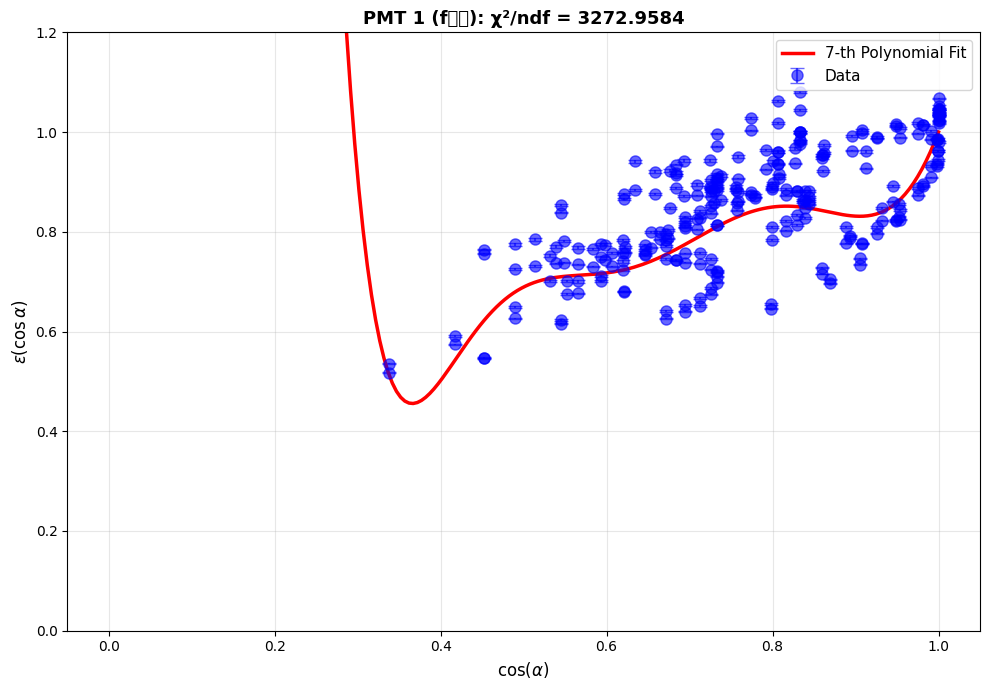

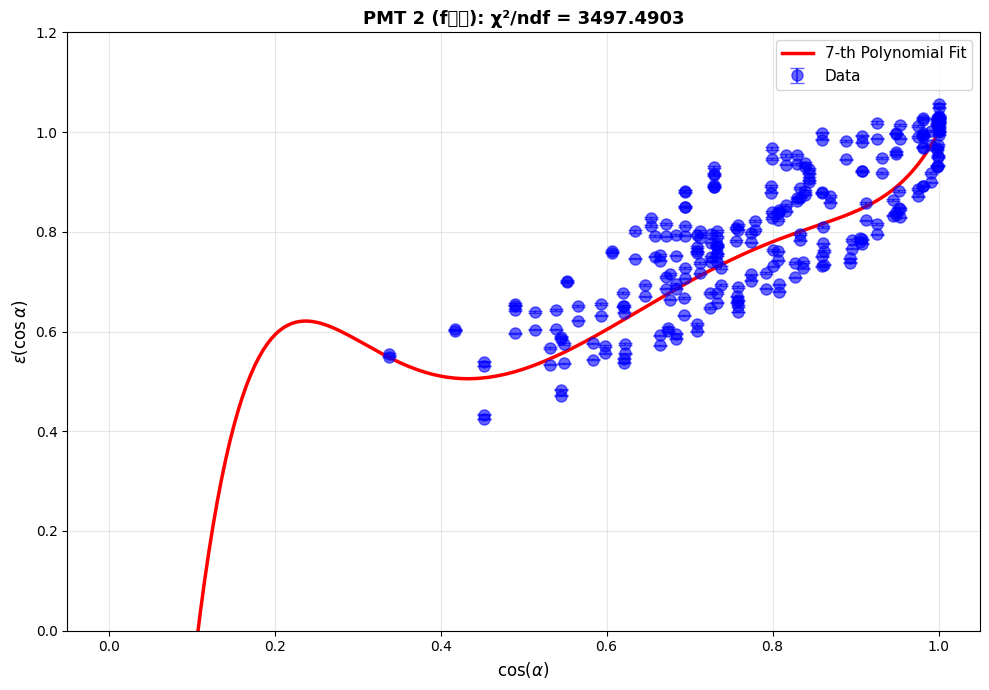

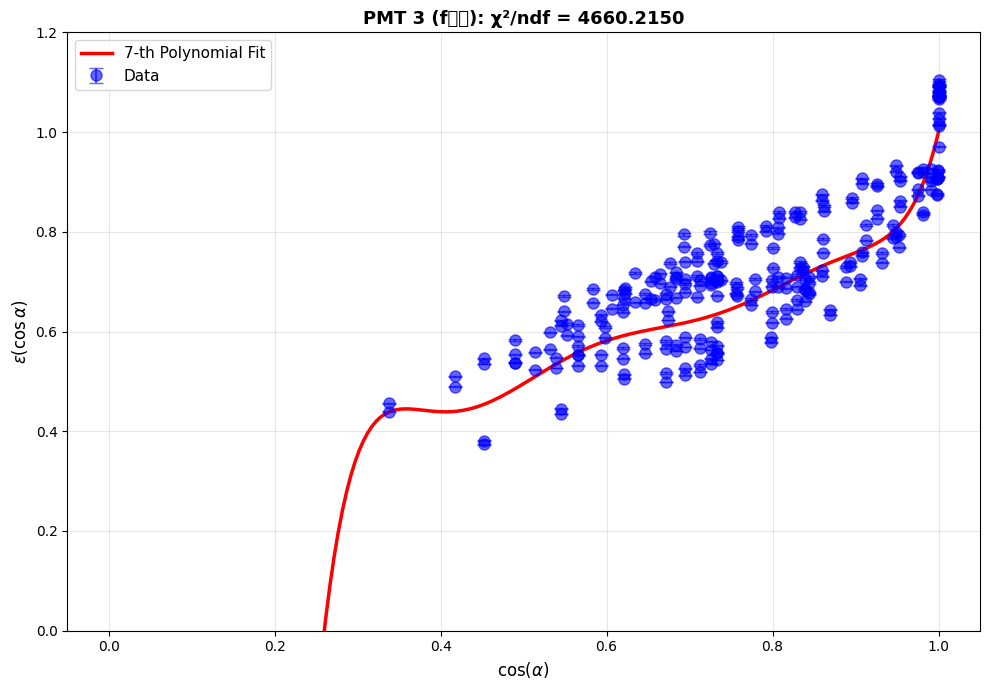

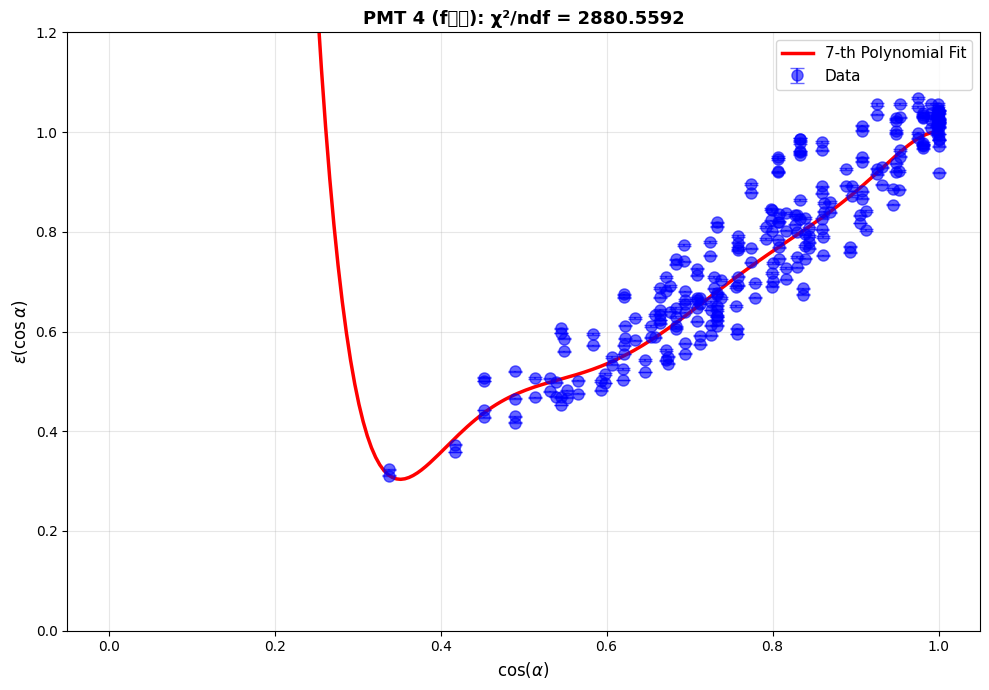

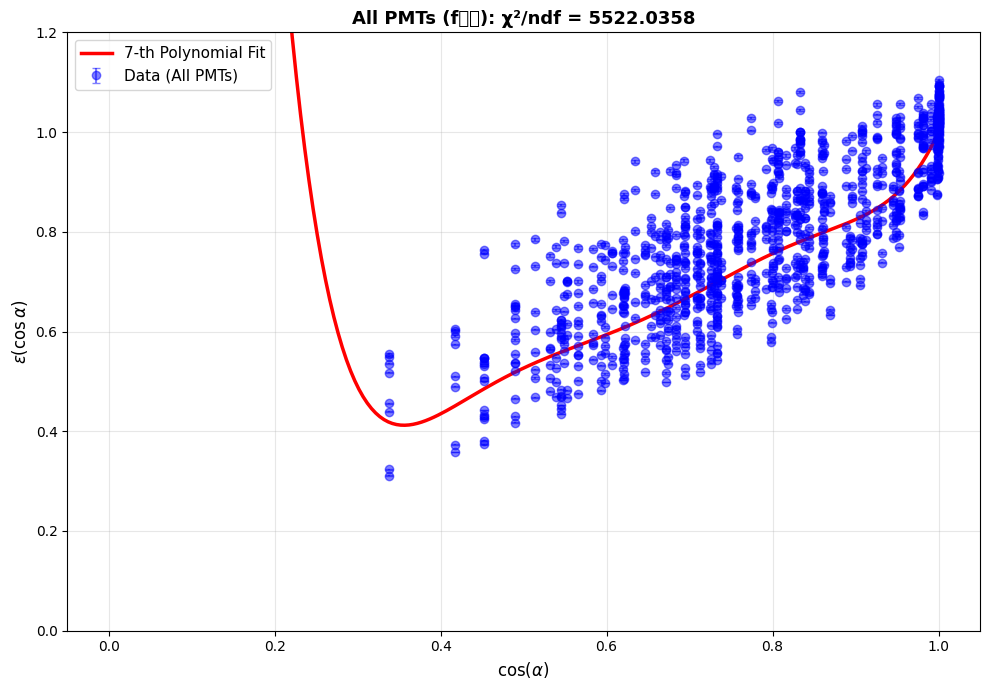


7次多項式フィッティング結果：g関数



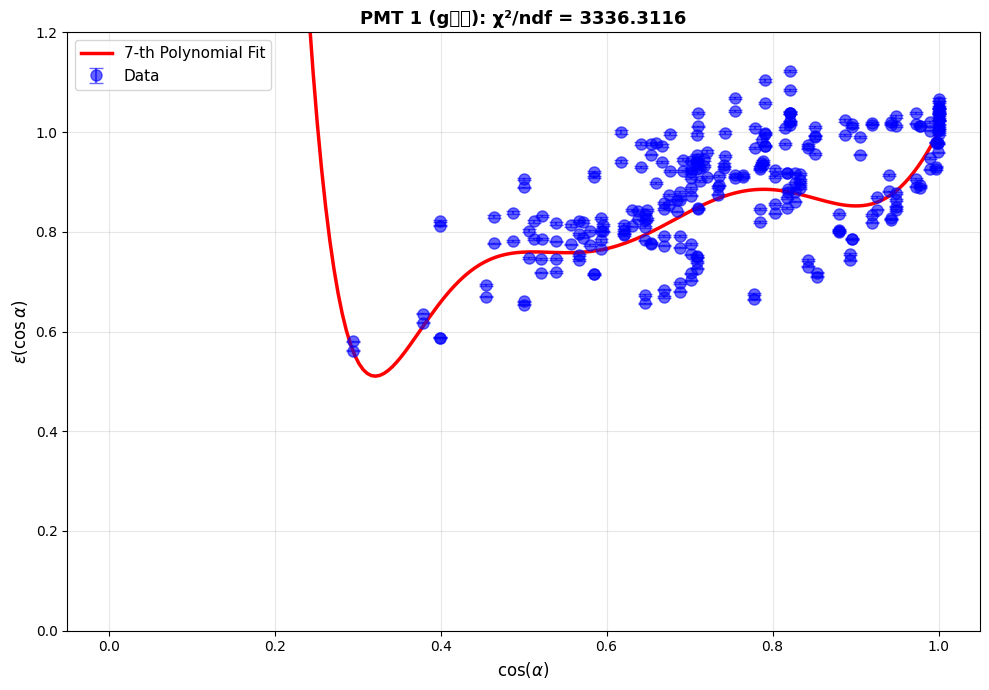

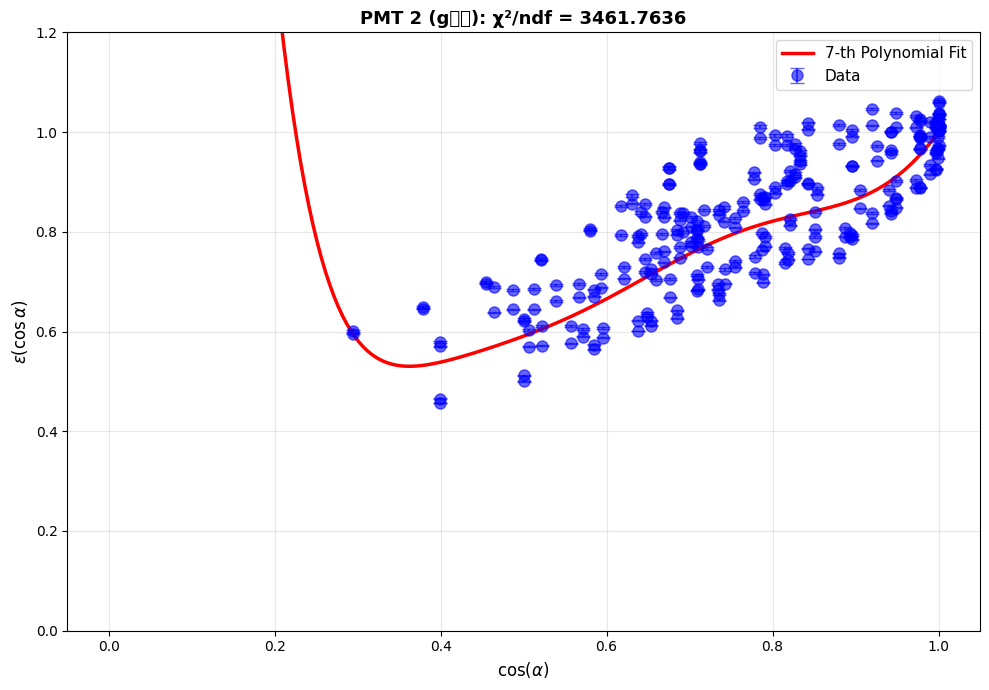

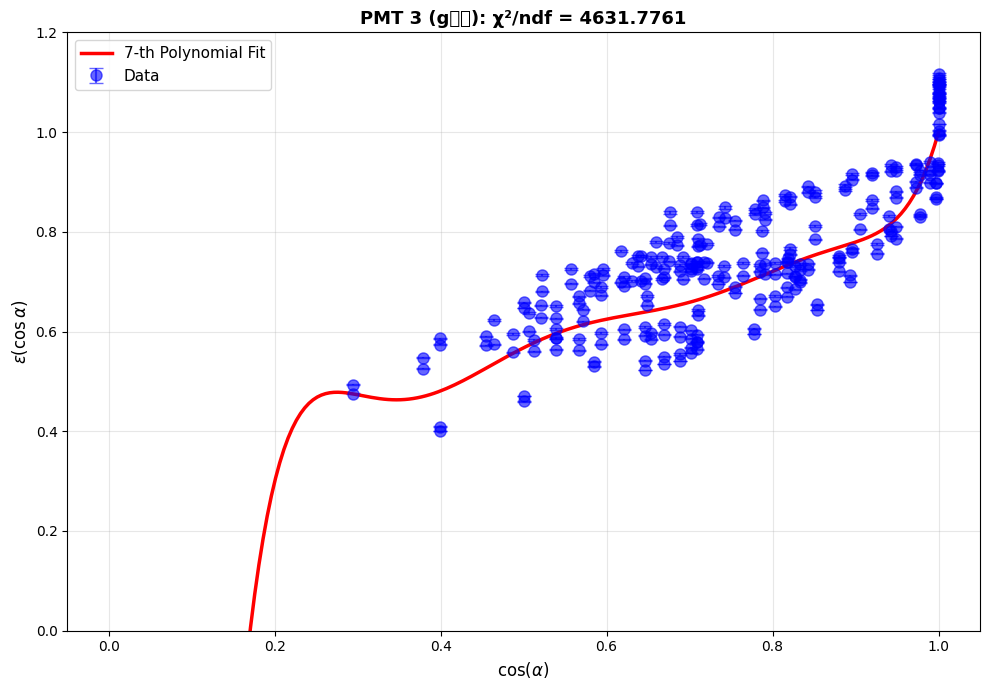

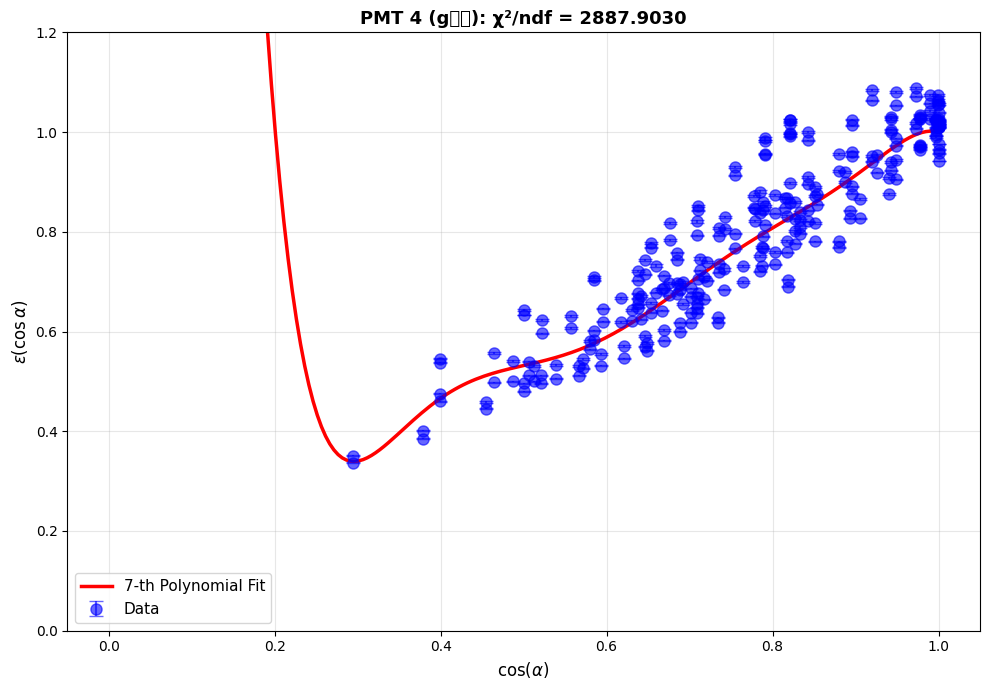

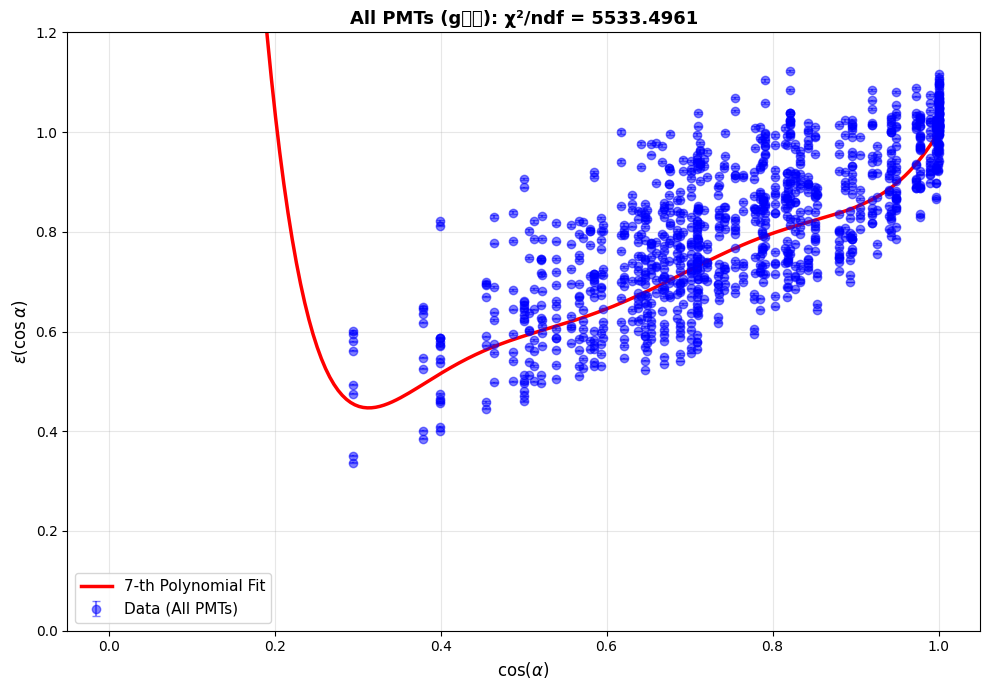

グラフ表示完了



In [38]:
# ============================================================================
# フィッティング結果のグラフ表示
# ============================================================================

print(f"\n{'='*100}")
print(f"7次多項式フィッティング結果：f関数")
print(f"{'='*100}\n")

# f関数：PMTごと
for pmt_num in [1, 2, 3, 4]:
    if pmt_num in poly_fit_results_f:
        result = poly_fit_results_f[pmt_num]
        pmt_data = df_f[df_f['#PMT_num'] == pmt_num].copy()
        pmt_data = pmt_data[pmt_data['Charge(pC)'] > 0]
        pmt_data = pmt_data[pmt_data['epsilon_f'] < 10]
        pmt_data = pmt_data[pmt_data['epsilon_f'].notna()]
        
        if len(pmt_data) > 0:
            fig, ax = plt.subplots(figsize=(10, 7))
            ax.errorbar(pmt_data['cos_alpha_pmt'], pmt_data['epsilon_f'], 
                       yerr=pmt_data['epsilon_f_err'],
                       fmt='o', alpha=0.6, capsize=5, markersize=8, label='Data', color='blue')
            
            # フィット曲線
            x_fit = np.linspace(0, 1, 200)
            y_fit = result['c0'] + result['c1']*x_fit + result['c2']*x_fit**2 + \
                    result['c3']*x_fit**3 + result['c4']*x_fit**4 + \
                    result['c5']*x_fit**5 + result['c6']*x_fit**6 + result['c7']*x_fit**7
            ax.plot(x_fit, y_fit, 'r-', linewidth=2.5, label='7-th Polynomial Fit')
            
            ax.set_xlabel(r'$\cos(\alpha)$', fontsize=12)
            ax.set_ylabel(r'$\epsilon(\cos\alpha)$', fontsize=12)
            ax.set_title(f'PMT {pmt_num} (f関数): χ²/ndf = {result["chi2_ndf"]:.4f}', 
                        fontsize=13, fontweight='bold')
            ax.set_ylim(0, 1.2)
            ax.grid(True, alpha=0.3)
            ax.legend(fontsize=11)
            plt.tight_layout()
            plt.show()

# f関数：全PMT統合
if 'ALL' in poly_fit_results_f:
    result = poly_fit_results_f['ALL']
    
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.errorbar(df_f_all['cos_alpha_pmt'], df_f_all['epsilon_f'],
               yerr=df_f_all['epsilon_f_err'],
               fmt='o', alpha=0.5, capsize=3, markersize=6, label='Data (All PMTs)', color='blue')
    
    x_fit = np.linspace(0, 1, 200)
    y_fit = result['c0'] + result['c1']*x_fit + result['c2']*x_fit**2 + \
            result['c3']*x_fit**3 + result['c4']*x_fit**4 + \
            result['c5']*x_fit**5 + result['c6']*x_fit**6 + result['c7']*x_fit**7
    ax.plot(x_fit, y_fit, 'r-', linewidth=2.5, label='7-th Polynomial Fit')
    
    ax.set_xlabel(r'$\cos(\alpha)$', fontsize=12)
    ax.set_ylabel(r'$\epsilon(\cos\alpha)$', fontsize=12)
    ax.set_title(f'All PMTs (f関数): χ²/ndf = {result["chi2_ndf"]:.4f}', 
                fontsize=13, fontweight='bold')
    ax.set_ylim(0, 1.2)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=11)
    plt.tight_layout()
    plt.show()

# g関数も同様
print(f"\n{'='*100}")
print(f"7次多項式フィッティング結果：g関数")
print(f"{'='*100}\n")

for pmt_num in [1, 2, 3, 4]:
    if pmt_num in poly_fit_results_g:
        result = poly_fit_results_g[pmt_num]
        pmt_data = df_g[df_g['#PMT_num'] == pmt_num].copy()
        pmt_data = pmt_data[pmt_data['Charge(pC)'] > 0]
        pmt_data = pmt_data[pmt_data['epsilon_g'] < 10]
        pmt_data = pmt_data[pmt_data['epsilon_g'].notna()]
        
        if len(pmt_data) > 0:
            fig, ax = plt.subplots(figsize=(10, 7))
            ax.errorbar(pmt_data['cos_alpha_pmt'], pmt_data['epsilon_g'],
                       yerr=pmt_data['epsilon_g_err'],
                       fmt='o', alpha=0.6, capsize=5, markersize=8, label='Data', color='blue')
            
            x_fit = np.linspace(0, 1, 200)
            y_fit = result['c0'] + result['c1']*x_fit + result['c2']*x_fit**2 + \
                    result['c3']*x_fit**3 + result['c4']*x_fit**4 + \
                    result['c5']*x_fit**5 + result['c6']*x_fit**6 + result['c7']*x_fit**7
            ax.plot(x_fit, y_fit, 'r-', linewidth=2.5, label='7-th Polynomial Fit')
            
            ax.set_xlabel(r'$\cos(\alpha)$', fontsize=12)
            ax.set_ylabel(r'$\epsilon(\cos\alpha)$', fontsize=12)
            ax.set_title(f'PMT {pmt_num} (g関数): χ²/ndf = {result["chi2_ndf"]:.4f}',
                        fontsize=13, fontweight='bold')
            ax.set_ylim(0, 1.2)
            ax.grid(True, alpha=0.3)
            ax.legend(fontsize=11)
            plt.tight_layout()
            plt.show()

if 'ALL' in poly_fit_results_g:
    result = poly_fit_results_g['ALL']
    
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.errorbar(df_g_all['cos_alpha_pmt'], df_g_all['epsilon_g'],
               yerr=df_g_all['epsilon_g_err'],
               fmt='o', alpha=0.5, capsize=3, markersize=6, label='Data (All PMTs)', color='blue')
    
    x_fit = np.linspace(0, 1, 200)
    y_fit = result['c0'] + result['c1']*x_fit + result['c2']*x_fit**2 + \
            result['c3']*x_fit**3 + result['c4']*x_fit**4 + \
            result['c5']*x_fit**5 + result['c6']*x_fit**6 + result['c7']*x_fit**7
    ax.plot(x_fit, y_fit, 'r-', linewidth=2.5, label='7-th Polynomial Fit')
    
    ax.set_xlabel(r'$\cos(\alpha)$', fontsize=12)
    ax.set_ylabel(r'$\epsilon(\cos\alpha)$', fontsize=12)
    ax.set_title(f'All PMTs (g関数): χ²/ndf = {result["chi2_ndf"]:.4f}',
                fontsize=13, fontweight='bold')
    ax.set_ylim(0, 1.2)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=11)
    plt.tight_layout()
    plt.show()

print(f"{'='*100}")
print(f"グラフ表示完了")
print(f"{'='*100}\n")

In [39]:
# ============================================================================
# 方法A：フィッティング結果の詳細表示（c0~c7の全パラメータ）
# ============================================================================

import pandas as pd

def display_fit_results_table(poly_fit_results, model_type='f'):
    """フィッティング結果を表形式で表示"""
    print(f"\n{'='*120}")
    print(f"{model_type}関数 - 方法A（制約事後適用）：全パラメータ表")
    print(f"{'='*120}\n")
    
    # 全PMTと個別PMTのリスト
    pmt_list = ['ALL', 1, 2, 3, 4]
    
    for pmt_id in pmt_list:
        if pmt_id not in poly_fit_results:
            continue
            
        result = poly_fit_results[pmt_id]
        
        print(f"\n{'─'*120}")
        print(f"PMT {pmt_id} ({model_type}関数)")
        print(f"{'─'*120}")
        print(f"データ点数: {result['n_points']}")
        print(f"χ²/ndf: {result['chi2_ndf']:.6f}")
        print(f"制約条件（Σcᵢ）: {result['constraint_sum']:.6f} (1.0になるべき)")
        print()
        
        # パラメータテーブル作成
        param_data = []
        for i in range(8):
            param_name = f"c{i}"
            param_val = result[f'c{i}']
            param_err = result[f'c{i}_err']
            param_data.append({
                'パラメータ': param_name,
                '値': f"{param_val:.8f}",
                '誤差': f"{param_err:.4e}"
            })
        
        df_params = pd.DataFrame(param_data)
        print(df_params.to_string(index=False))
        print()

# f関数の結果表示
display_fit_results_table(poly_fit_results_f, model_type='f')

# g関数の結果表示
display_fit_results_table(poly_fit_results_g, model_type='g')

print(f"\n{'='*120}")
print(f"方法A：全結果表示完了")
print(f"{'='*120}\n")


f関数 - 方法A（制約事後適用）：全パラメータ表


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PMT ALL (f関数)
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
データ点数: 1064
χ²/ndf: 5522.035846
制約条件（Σcᵢ）: 1.000000 (1.0になるべき)

パラメータ              値         誤差
   c0    20.41397644 1.8970e+02
   c1  -216.38385268 6.0852e+00
   c2   957.00861155 2.9483e+01
   c3 -2241.63372346 7.7507e+01
   c4  2996.48749992 1.1960e+02
   c5 -2262.92064694 1.0848e+02
   c6   876.61929109 5.3637e+01
   c7  -128.59115591 1.1166e+01


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PMT 1 (f関数)
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
データ点数: 266
χ²/ndf: 3272.958356
制約条件（Σcᵢ）: 1.000000 (1.0になるべき)

パラメータ               値         誤差
   c0    12

In [40]:
# ============================================================================
# 7次多項式フィッティング：方法B（再パラメータ化）
# ============================================================================

# 方法Bのフィッティング結果を格納
poly_fit_results_f_B = {}
poly_fit_results_g_B = {}

print(f"\n{'='*100}")
print(f"7次多項式フィッティング：方法B（再パラメータ化）")
print(f"{'='*100}\n")

# ============================================================================
# f関数：PMTごとのフィッティング（方法B）
# ============================================================================
print(f"\n{'-'*100}")
print(f"f関数：PMTごとのフィッティング（方法B）")
print(f"{'-'*100}\n")

# df_fは既に計算済み
for pmt_num in [1, 2, 3, 4]:
    pmt_data = df_f[df_f['#PMT_num'] == pmt_num].copy()
    
    # フィルター適用
    pmt_data = pmt_data[pmt_data['Charge(pC)'] > 0]
    pmt_data = pmt_data[pmt_data['epsilon_f'] < 10]
    pmt_data = pmt_data[pmt_data['epsilon_f'].notna()]
    
    if len(pmt_data) > 7:  # パラメータ数より多い必要がある
        cos_alpha = pmt_data['cos_alpha_pmt'].values
        epsilon = pmt_data['epsilon_f'].values
        epsilon_err = pmt_data['epsilon_f_err'].values
        
        result, poly_func = fit_epsilon_polynomial(
            cos_alpha, epsilon, epsilon_err,
            model_type='f', pmt_num=pmt_num, method='B'
        )
        
        if result is not None:
            poly_fit_results_f_B[pmt_num] = result
            
            print(f"PMT {pmt_num} (f関数, 方法B):")
            print(f"  n_points: {result['n_points']}")
            print(f"  chi2/ndf: {result['chi2_ndf']:.6f}")
            print(f"  Σcᵢ = {result['constraint_sum']:.6f} (1.0になるはず)")
            print()

# 全PMTを統合したフィッティング（方法B）
print(f"\nf関数：全PMT統合フィッティング（方法B）")
df_f_all = df_f[df_f['Charge(pC)'] > 0].copy()
df_f_all = df_f_all[df_f_all['epsilon_f'] < 10].copy()
df_f_all = df_f_all[df_f_all['epsilon_f'].notna()].copy()

if len(df_f_all) > 7:
    cos_alpha_all = df_f_all['cos_alpha_pmt'].values
    epsilon_all = df_f_all['epsilon_f'].values
    epsilon_err_all = df_f_all['epsilon_f_err'].values
    
    result_all_f_B, poly_func_all_f_B = fit_epsilon_polynomial(
        cos_alpha_all, epsilon_all, epsilon_err_all,
        model_type='f', pmt_num='ALL', method='B'
    )
    
    if result_all_f_B is not None:
        poly_fit_results_f_B['ALL'] = result_all_f_B
        print(f"全PMT (f関数, 方法B):")
        print(f"  n_points: {result_all_f_B['n_points']}")
        print(f"  chi2/ndf: {result_all_f_B['chi2_ndf']:.6f}")
        print(f"  Σcᵢ = {result_all_f_B['constraint_sum']:.6f}")

# ============================================================================
# g関数：PMTごとのフィッティング（方法B）
# ============================================================================
print(f"\n{'-'*100}")
print(f"g関数：PMTごとのフィッティング（方法B）")
print(f"{'-'*100}\n")

# df_gは既に計算済み
for pmt_num in [1, 2, 3, 4]:
    pmt_data = df_g[df_g['#PMT_num'] == pmt_num].copy()
    
    pmt_data = pmt_data[pmt_data['Charge(pC)'] > 0]
    pmt_data = pmt_data[pmt_data['epsilon_g'] < 10]
    pmt_data = pmt_data[pmt_data['epsilon_g'].notna()]
    
    if len(pmt_data) > 7:
        cos_alpha = pmt_data['cos_alpha_pmt'].values
        epsilon = pmt_data['epsilon_g'].values
        epsilon_err = pmt_data['epsilon_g_err'].values
        
        result, poly_func = fit_epsilon_polynomial(
            cos_alpha, epsilon, epsilon_err,
            model_type='g', pmt_num=pmt_num, method='B'
        )
        
        if result is not None:
            poly_fit_results_g_B[pmt_num] = result
            
            print(f"PMT {pmt_num} (g関数, 方法B):")
            print(f"  n_points: {result['n_points']}")
            print(f"  chi2/ndf: {result['chi2_ndf']:.6f}")
            print(f"  Σcᵢ = {result['constraint_sum']:.6f}")
            print()

# 全PMT統合（方法B）
print(f"\ng関数：全PMT統合フィッティング（方法B）")
df_g_all = df_g[df_g['Charge(pC)'] > 0].copy()
df_g_all = df_g_all[df_g_all['epsilon_g'] < 10].copy()
df_g_all = df_g_all[df_g_all['epsilon_g'].notna()].copy()

if len(df_g_all) > 7:
    cos_alpha_all = df_g_all['cos_alpha_pmt'].values
    epsilon_all = df_g_all['epsilon_g'].values
    epsilon_err_all = df_g_all['epsilon_g_err'].values
    
    result_all_g_B, poly_func_all_g_B = fit_epsilon_polynomial(
        cos_alpha_all, epsilon_all, epsilon_err_all,
        model_type='g', pmt_num='ALL', method='B'
    )
    
    if result_all_g_B is not None:
        poly_fit_results_g_B['ALL'] = result_all_g_B
        print(f"全PMT (g関数, 方法B):")
        print(f"  n_points: {result_all_g_B['n_points']}")
        print(f"  chi2/ndf: {result_all_g_B['chi2_ndf']:.6f}")
        print(f"  Σcᵢ = {result_all_g_B['constraint_sum']:.6f}")

print(f"\n{'='*100}")
print(f"方法B：フィッティング完了")
print(f"{'='*100}\n")


7次多項式フィッティング：方法B（再パラメータ化）


----------------------------------------------------------------------------------------------------
f関数：PMTごとのフィッティング（方法B）
----------------------------------------------------------------------------------------------------

PMT 1 (f関数, 方法B):
  n_points: 266
  chi2/ndf: 3219.274821
  Σcᵢ = 1.000000 (1.0になるはず)

PMT 2 (f関数, 方法B):
  n_points: 266
  chi2/ndf: 3474.572996
  Σcᵢ = 1.000000 (1.0になるはず)

PMT 3 (f関数, 方法B):
  n_points: 266
  chi2/ndf: 4607.339966
  Σcᵢ = 1.000000 (1.0になるはず)

PMT 4 (f関数, 方法B):
  n_points: 266
  chi2/ndf: 2876.159894
  Σcᵢ = 1.000000 (1.0になるはず)


f関数：全PMT統合フィッティング（方法B）
全PMT (f関数, 方法B):
  n_points: 1064
  chi2/ndf: 5491.826403
  Σcᵢ = 1.000000

----------------------------------------------------------------------------------------------------
g関数：PMTごとのフィッティング（方法B）
----------------------------------------------------------------------------------------------------

PMT 1 (g関数, 方法B):
  n_points: 266
  chi2/ndf: 3305.706648
  Σcᵢ = 1.000

In [41]:
# ============================================================================
# 方法B：フィッティング結果の詳細表示
# ============================================================================

def display_fit_results_table_B(poly_fit_results, model_type='f'):
    """方法Bのフィッティング結果を表形式で表示"""
    print(f"\n{'='*120}")
    print(f"{model_type}関数 - 方法B（再パラメータ化）：全パラメータ表")
    print(f"{'='*120}\n")
    
    # 全PMTと個別PMTのリスト
    pmt_list = ['ALL', 1, 2, 3, 4]
    
    for pmt_id in pmt_list:
        if pmt_id not in poly_fit_results:
            continue
            
        result = poly_fit_results[pmt_id]
        
        print(f"\n{'─'*120}")
        print(f"PMT {pmt_id} ({model_type}関数)")
        print(f"{'─'*120}")
        print(f"データ点数: {result['n_points']}")
        print(f"χ²/ndf: {result['chi2_ndf']:.6f}")
        print(f"制約条件（Σcᵢ）: {result['constraint_sum']:.6f} (1.0になるべき)")
        print(f"注：方法Bでは制約を組み込んだ7個のパラメータでフィッティング")
        print()
        
        # 変換後のc0~c7を表示
        print("【パラメータ (c0~c7)】")
        param_data_c = []
        for i in range(8):
            param_name = f"c{i}"
            param_val = result[f'c{i}']
            param_err = result[f'c{i}_err']
            param_data_c.append({
                'パラメータ': param_name,
                '値': f"{param_val:.8f}",
                '誤差': f"{param_err:.4e}"
            })
        
        df_params_c = pd.DataFrame(param_data_c)
        print(df_params_c.to_string(index=False))
        print()

# f関数の結果表示（方法B）
display_fit_results_table_B(poly_fit_results_f_B, model_type='f')

# g関数の結果表示（方法B）
display_fit_results_table_B(poly_fit_results_g_B, model_type='g')

print(f"\n{'='*120}")
print(f"方法B：全結果表示完了")
print(f"{'='*120}\n")


f関数 - 方法B（再パラメータ化）：全パラメータ表


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PMT ALL (f関数)
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
データ点数: 1064
χ²/ndf: 5491.826403
制約条件（Σcᵢ）: 1.000000 (1.0になるべき)
注：方法Bでは制約を組み込んだ7個のパラメータでフィッティング

【パラメータ (c0~c7)】
パラメータ              値         誤差
   c0    27.19957061 1.8575e+02
   c1  -297.26027332 5.9780e+00
   c2  1360.78310773 2.8938e+01
   c3 -3336.55586353 7.6000e+01
   c4  4740.51458060 1.1714e+02
   c5 -3896.72108189 1.0614e+02
   c6  1711.10742560 5.2409e+01
   c7  -308.06746580 1.0895e+01


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PMT 1 (f関数)
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
データ点数: 266
χ²/ndf: 3219.274821
制約条件（Σcᵢ）: 1.000000 (1.0になる


7次多項式フィッティング結果（方法B）：f関数



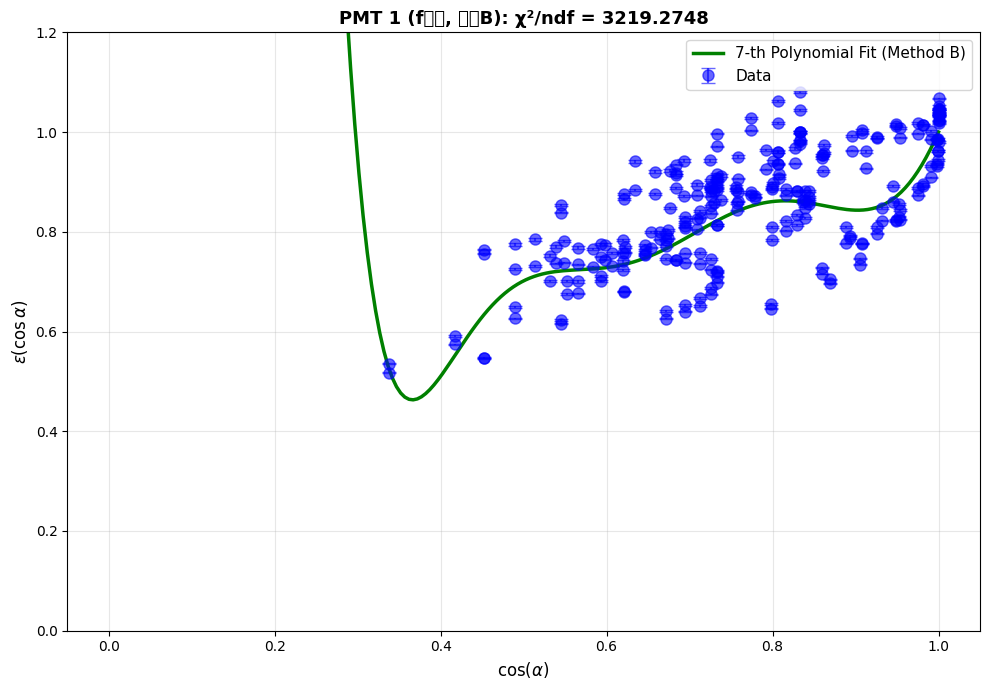

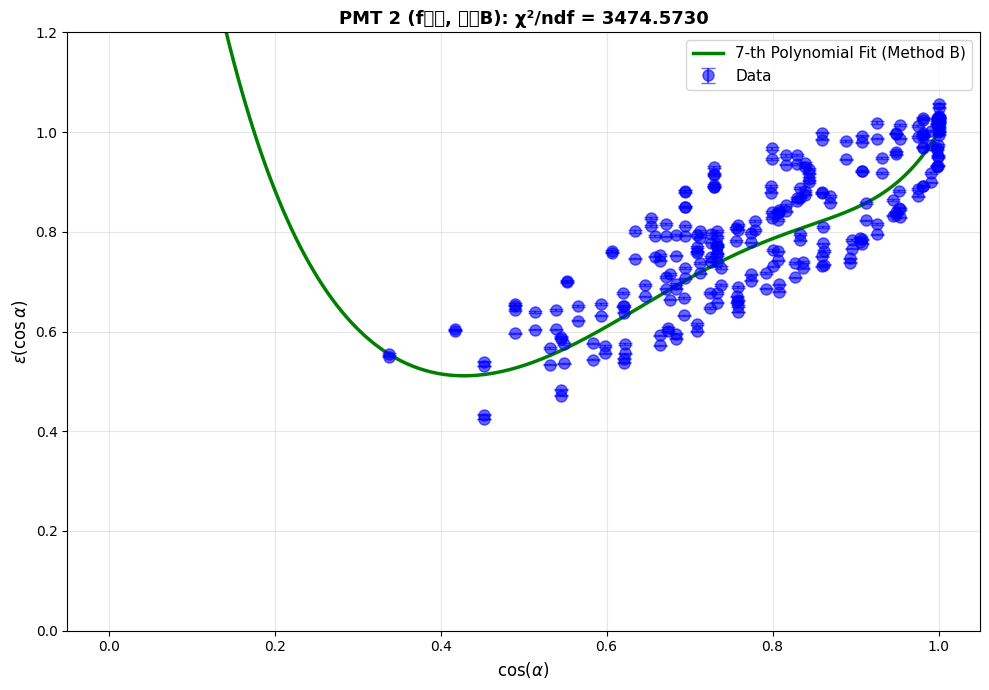

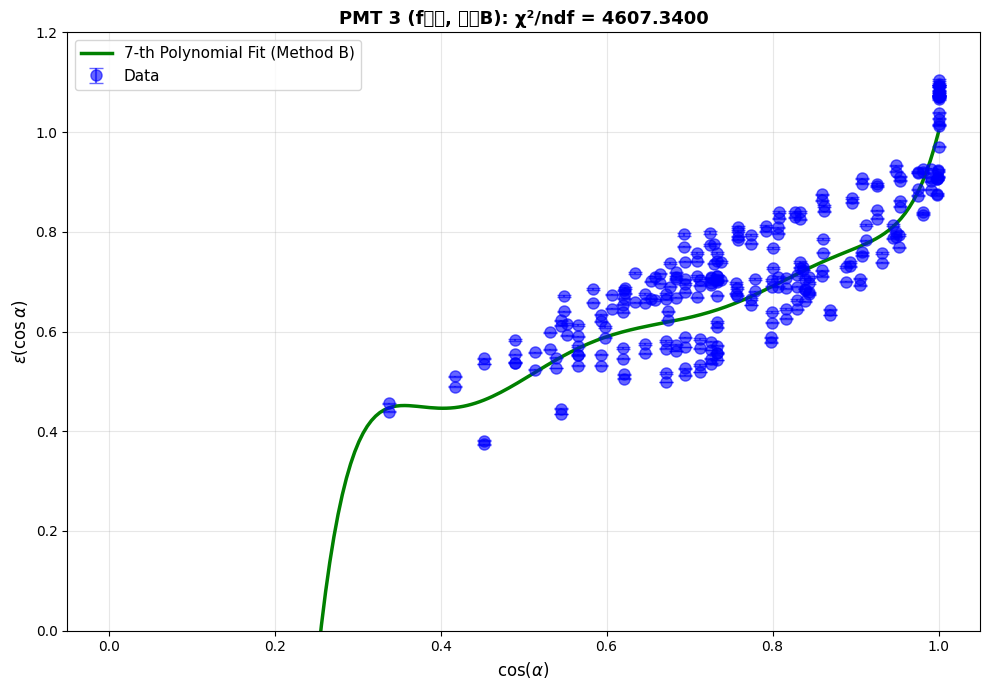

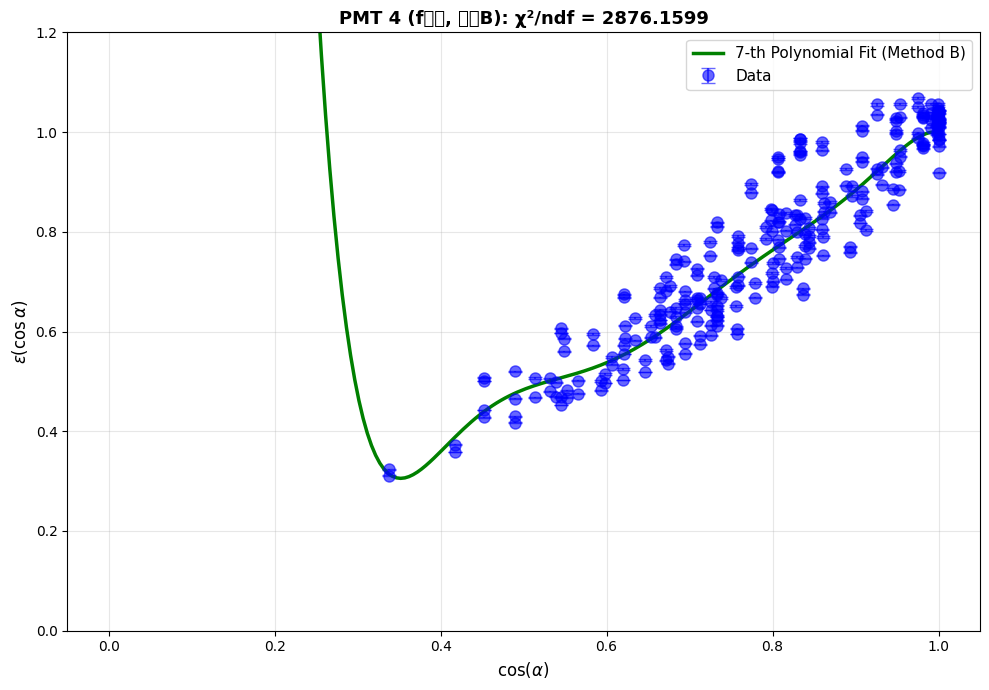

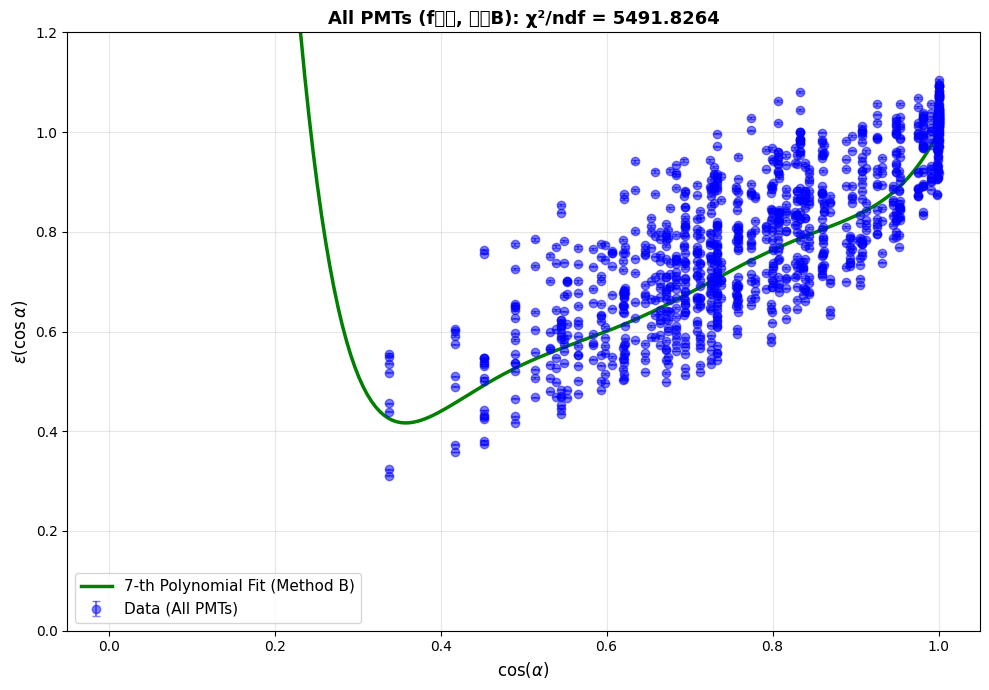


7次多項式フィッティング結果（方法B）：g関数



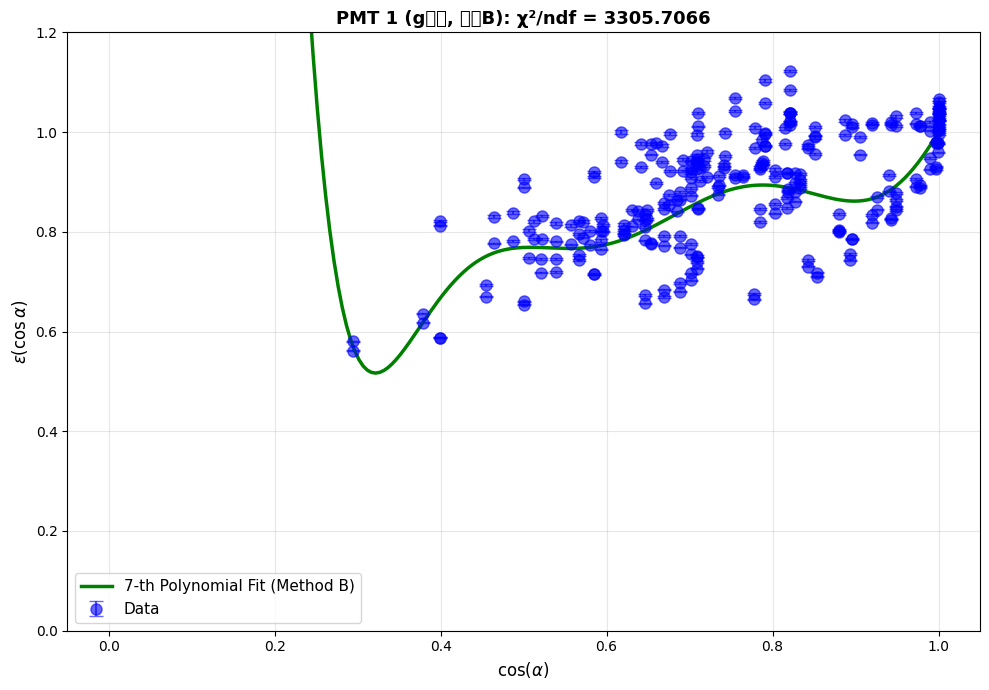

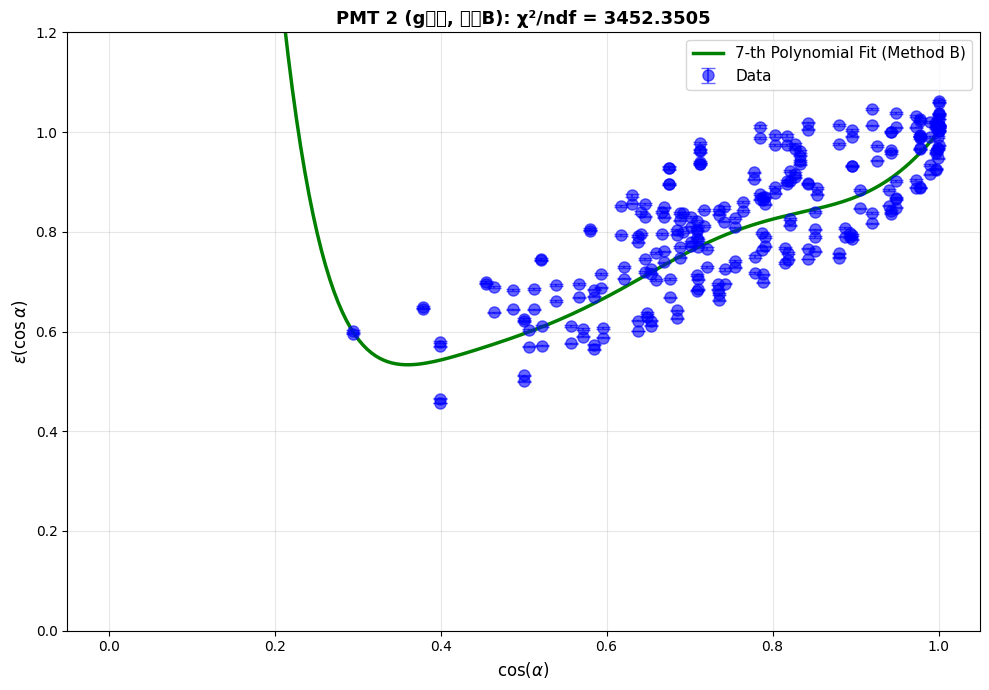

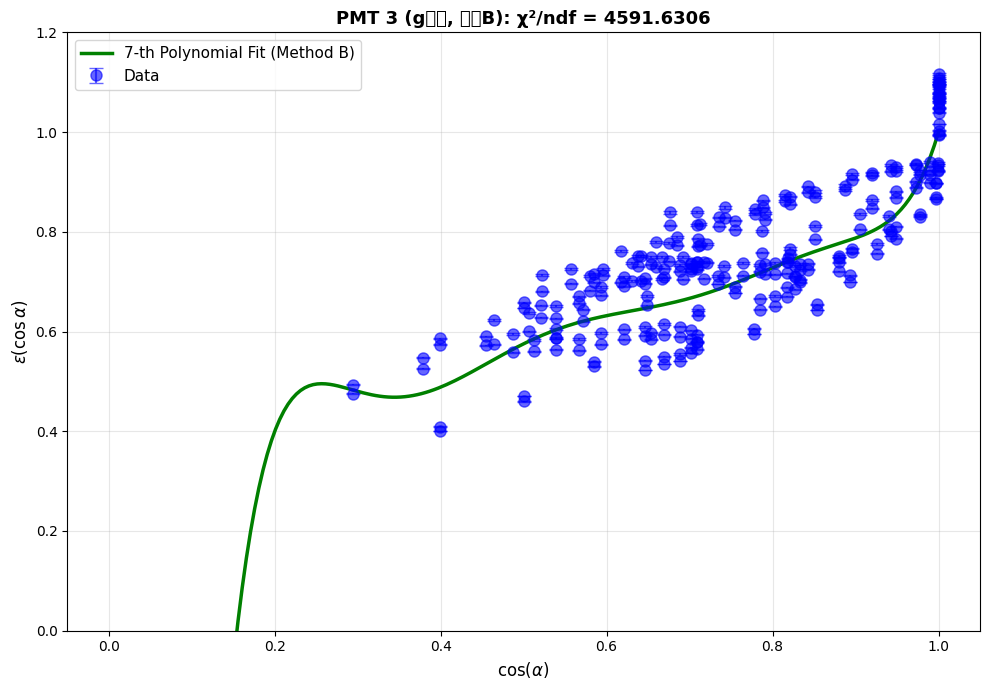

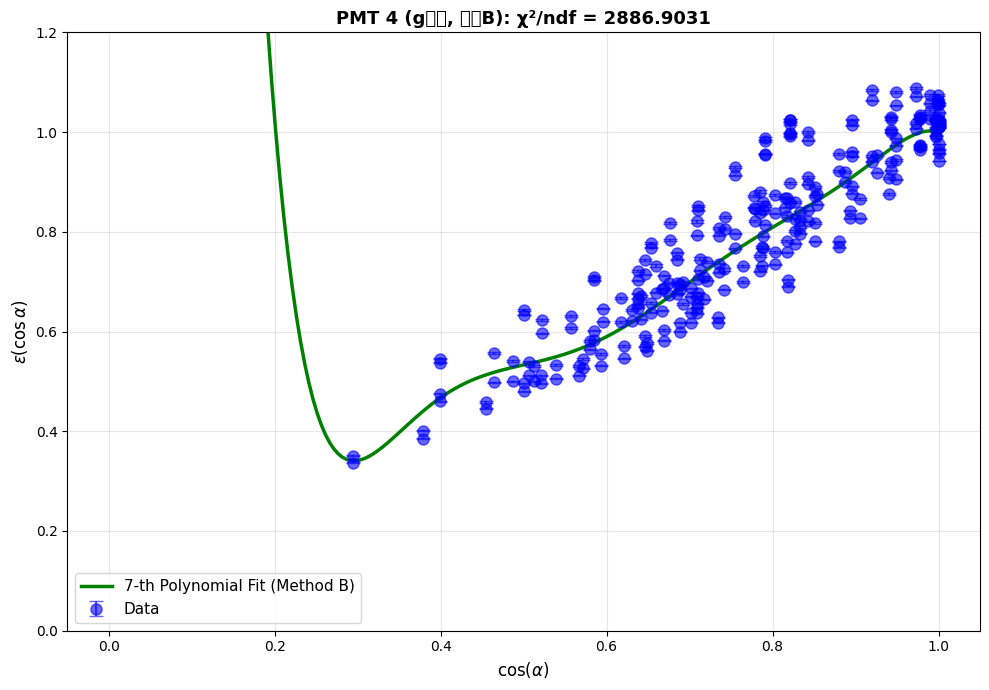

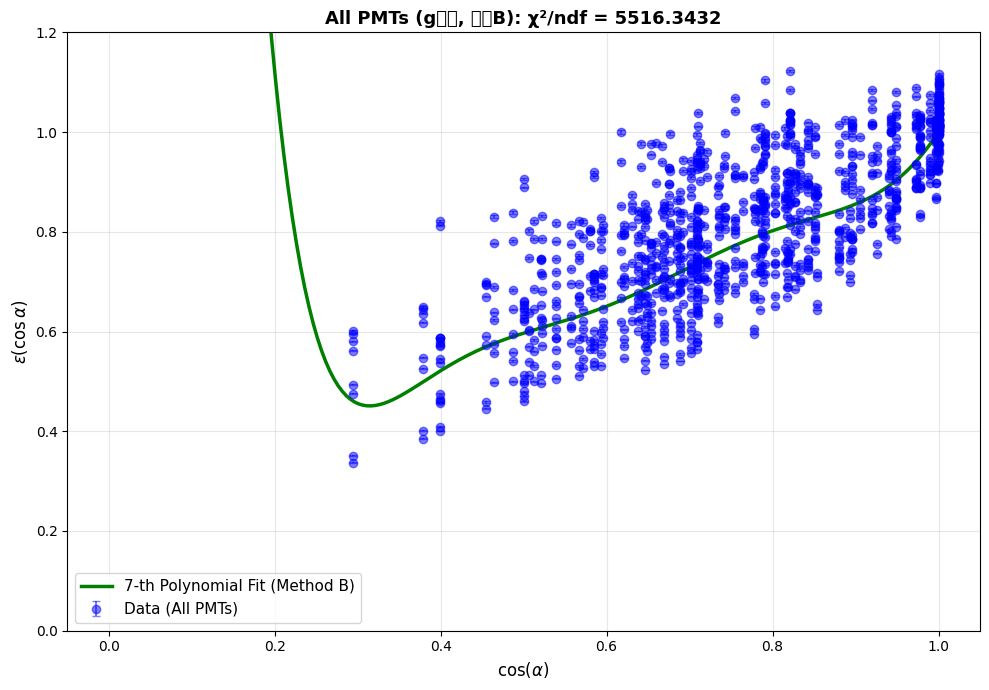

方法Bグラフ表示完了



In [42]:
# ============================================================================
# 方法B：フィッティング結果のグラフ表示
# ============================================================================

print(f"\n{'='*100}")
print(f"7次多項式フィッティング結果（方法B）：f関数")
print(f"{'='*100}\n")

# f関数：PMTごと（方法B）
for pmt_num in [1, 2, 3, 4]:
    if pmt_num in poly_fit_results_f_B:
        result = poly_fit_results_f_B[pmt_num]
        pmt_data = df_f[df_f['#PMT_num'] == pmt_num].copy()
        pmt_data = pmt_data[pmt_data['Charge(pC)'] > 0]
        pmt_data = pmt_data[pmt_data['epsilon_f'] < 10]
        pmt_data = pmt_data[pmt_data['epsilon_f'].notna()]
        
        if len(pmt_data) > 0:
            fig, ax = plt.subplots(figsize=(10, 7))
            ax.errorbar(pmt_data['cos_alpha_pmt'], pmt_data['epsilon_f'], 
                       yerr=pmt_data['epsilon_f_err'],
                       fmt='o', alpha=0.6, capsize=5, markersize=8, label='Data', color='blue')
            
            # フィット曲線（方法B）
            x_fit = np.linspace(0, 1, 200)
            y_fit = result['c0'] + result['c1']*x_fit + result['c2']*x_fit**2 + \
                    result['c3']*x_fit**3 + result['c4']*x_fit**4 + \
                    result['c5']*x_fit**5 + result['c6']*x_fit**6 + result['c7']*x_fit**7
            ax.plot(x_fit, y_fit, 'g-', linewidth=2.5, label='7-th Polynomial Fit (Method B)')
            
            ax.set_xlabel(r'$\cos(\alpha)$', fontsize=12)
            ax.set_ylabel(r'$\epsilon(\cos\alpha)$', fontsize=12)
            ax.set_title(f'PMT {pmt_num} (f関数, 方法B): χ²/ndf = {result["chi2_ndf"]:.4f}', 
                        fontsize=13, fontweight='bold')
            ax.set_ylim(0, 1.2)
            ax.grid(True, alpha=0.3)
            ax.legend(fontsize=11)
            plt.tight_layout()
            plt.show()

# f関数：全PMT統合（方法B）
if 'ALL' in poly_fit_results_f_B:
    result = poly_fit_results_f_B['ALL']
    
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.errorbar(df_f_all['cos_alpha_pmt'], df_f_all['epsilon_f'],
               yerr=df_f_all['epsilon_f_err'],
               fmt='o', alpha=0.5, capsize=3, markersize=6, label='Data (All PMTs)', color='blue')
    
    x_fit = np.linspace(0, 1, 200)
    y_fit = result['c0'] + result['c1']*x_fit + result['c2']*x_fit**2 + \
            result['c3']*x_fit**3 + result['c4']*x_fit**4 + \
            result['c5']*x_fit**5 + result['c6']*x_fit**6 + result['c7']*x_fit**7
    ax.plot(x_fit, y_fit, 'g-', linewidth=2.5, label='7-th Polynomial Fit (Method B)')
    
    ax.set_xlabel(r'$\cos(\alpha)$', fontsize=12)
    ax.set_ylabel(r'$\epsilon(\cos\alpha)$', fontsize=12)
    ax.set_title(f'All PMTs (f関数, 方法B): χ²/ndf = {result["chi2_ndf"]:.4f}', 
                fontsize=13, fontweight='bold')
    ax.set_ylim(0, 1.2)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=11)
    plt.tight_layout()
    plt.show()

# g関数も同様（方法B）
print(f"\n{'='*100}")
print(f"7次多項式フィッティング結果（方法B）：g関数")
print(f"{'='*100}\n")

for pmt_num in [1, 2, 3, 4]:
    if pmt_num in poly_fit_results_g_B:
        result = poly_fit_results_g_B[pmt_num]
        pmt_data = df_g[df_g['#PMT_num'] == pmt_num].copy()
        pmt_data = pmt_data[pmt_data['Charge(pC)'] > 0]
        pmt_data = pmt_data[pmt_data['epsilon_g'] < 10]
        pmt_data = pmt_data[pmt_data['epsilon_g'].notna()]
        
        if len(pmt_data) > 0:
            fig, ax = plt.subplots(figsize=(10, 7))
            ax.errorbar(pmt_data['cos_alpha_pmt'], pmt_data['epsilon_g'],
                       yerr=pmt_data['epsilon_g_err'],
                       fmt='o', alpha=0.6, capsize=5, markersize=8, label='Data', color='blue')
            
            x_fit = np.linspace(0, 1, 200)
            y_fit = result['c0'] + result['c1']*x_fit + result['c2']*x_fit**2 + \
                    result['c3']*x_fit**3 + result['c4']*x_fit**4 + \
                    result['c5']*x_fit**5 + result['c6']*x_fit**6 + result['c7']*x_fit**7
            ax.plot(x_fit, y_fit, 'g-', linewidth=2.5, label='7-th Polynomial Fit (Method B)')
            
            ax.set_xlabel(r'$\cos(\alpha)$', fontsize=12)
            ax.set_ylabel(r'$\epsilon(\cos\alpha)$', fontsize=12)
            ax.set_title(f'PMT {pmt_num} (g関数, 方法B): χ²/ndf = {result["chi2_ndf"]:.4f}',
                        fontsize=13, fontweight='bold')
            ax.set_ylim(0, 1.2)
            ax.grid(True, alpha=0.3)
            ax.legend(fontsize=11)
            plt.tight_layout()
            plt.show()

if 'ALL' in poly_fit_results_g_B:
    result = poly_fit_results_g_B['ALL']
    
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.errorbar(df_g_all['cos_alpha_pmt'], df_g_all['epsilon_g'],
               yerr=df_g_all['epsilon_g_err'],
               fmt='o', alpha=0.5, capsize=3, markersize=6, label='Data (All PMTs)', color='blue')
    
    x_fit = np.linspace(0, 1, 200)
    y_fit = result['c0'] + result['c1']*x_fit + result['c2']*x_fit**2 + \
            result['c3']*x_fit**3 + result['c4']*x_fit**4 + \
            result['c5']*x_fit**5 + result['c6']*x_fit**6 + result['c7']*x_fit**7
    ax.plot(x_fit, y_fit, 'g-', linewidth=2.5, label='7-th Polynomial Fit (Method B)')
    
    ax.set_xlabel(r'$\cos(\alpha)$', fontsize=12)
    ax.set_ylabel(r'$\epsilon(\cos\alpha)$', fontsize=12)
    ax.set_title(f'All PMTs (g関数, 方法B): χ²/ndf = {result["chi2_ndf"]:.4f}',
                fontsize=13, fontweight='bold')
    ax.set_ylim(0, 1.2)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=11)
    plt.tight_layout()
    plt.show()

print(f"{'='*100}")
print(f"方法Bグラフ表示完了")
print(f"{'='*100}\n")